# 0 Infrastructure

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pythonjsonlogger.defaults import time_default
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

torch.manual_seed(0)
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True
# torch.set_float32_matmul_precision('high')

def make_projection(D, d, device=device):
    A = torch.randn(D, d, device="cpu")
    Q, _ = torch.linalg.qr(A)
    Q = Q.to(device)
    return Q

# A 2d sample of n_points points that forms a swissroll
def sample_underlying_2d(n_points):
    theta = np.linspace(0, 4 * np.pi, n_points)
    r = theta / (4 * np.pi) * 2.0

    x = r * np.cos(theta)
    y = r * np.sin(theta)

    pts = np.stack([x, y], axis=1)

    pts += 0.02 * np.random.randn(*pts.shape)
    pts = torch.from_numpy(pts).float()
    return pts

C:\Users\57517\Desktop\Diffusion-ToyModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 Coding for the model for training

## 1.1 The model itself

In [2]:
class MLP5(nn.Module):
    def __init__(self, x_dim, hidden_dim, out_dim, t_dim=None):
        """
        x_dim: D  (x is [B, D])
        t_dim: D  (t is [B, D]) by default
        """
        super().__init__()
        self.x_dim = x_dim
        self.t_dim = x_dim if t_dim is None else t_dim

        in_dim = self.x_dim + self.t_dim

        layers = []
        dims = [in_dim] + [hidden_dim] * 5 + [out_dim]
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        x: [B, D]
        t: [B, D]  (per-dim time)
           (also allows [B] or [B,1], which will be broadcast to [B, t_dim])
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # [B, 1]

        if t.dim() == 2 and t.shape[1] == 1 and self.t_dim != 1:
            # broadcast scalar time to per-dim time if user passes [B,1]
            t = t.expand(-1, self.t_dim)  # [B, t_dim]

        assert x.dim() == 2 and x.shape[1] == self.x_dim, f"x should be [B, {self.x_dim}]"
        assert t.dim() == 2 and t.shape[1] == self.t_dim, f"t should be [B, {self.t_dim}]"

        t = t.to(dtype=x.dtype, device=x.device)
        inp = torch.cat([x, t], dim=-1)  # [B, D + t_dim]
        return self.net(inp)

In [3]:
def train_toy(
    D=16,
    d=2,
    target_type="data",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
):
    P = make_projection(D, d)  # [D, 2]
    x_hat = sample_underlying_2d(n_samples).to(device)  # [N, 2]
    x = x_hat @ P.t()  # This projects (places) the 2D data into D-dim data on a hyperplane. It still chooses an orthogonal basis.
    
    sigma = x.std() / 3.0
    print(f"Data std: {x.std().item():.4f}")
    print(f"Using sigma: {sigma.item():.4f}")
    print(f"Data shape: {x.shape}")

    dataset = TensorDataset(x)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    model = MLP5(x_dim=D, hidden_dim=256, out_dim=D, t_dim=D).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs), desc=f"Training D={D}, target={target_type}"):
        for step, (x_batch,) in enumerate(loader):
            x_1 = x_batch.to(device)  # [B, D]

            B = x_1.size(0)
            x_1 = x_1 / sigma

            #  t ~ Uniform(0,1), asynchronous time for each dim
            t = torch.rand((B, D), device=device)
            
            x_0 = torch.randn_like(x_1)
            x_t = t * x_1 + (1 - t) * x_0
            # [B, 2] * [B, 2] + [B, 2] * [B, 2]
            
            model_pred = model(x_t, t)

            if target_type == "data":
                dnorm = 1.0
                v_target = (x_1 - x_t) / dnorm
                v_pred = (model_pred - x_t) / dnorm
                loss = ((v_target - v_pred) ** 2).mean()

            elif target_type == "v":
                v_target = x_1 - x_0
                loss = ((v_target - model_pred) ** 2).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"[D={D}] Epoch {epoch + 1}/{epochs} | {target_type}-prediction loss: {loss.item():.4f}")

    return model, P, x_hat, x, sigma

## 1.2 Sampling algorithm

In [4]:
def compute_velocity(pred, x_t, t, target_type, eps=1e-4):
    """
    from data to velocity

    :param pred: model prediction (N, D)
    :param x_t: current noisy data (N, D)
    :param t: noise level (N, D)
    :param target_type: "data" or "v"
    :param eps: a safe epsilon for eliminating the possibiity of division by 0
    :return: velocity (N, D)
    """
    if target_type == "data":
        # if the model predicts x_1, the velocity is given by
        # v = (X_1 - X_t) / (1 - t)
        dist = torch.clamp(1.0-t, min = eps)
        vp = (pred - x_t) / dist
    elif target_type == "v":
        # if the model predicts v, just use v as velocity
        vp = pred
    else:
        raise ValueError(f"Unknown target_type: {target_type}")

    return vp

In [45]:
def show_point(x, P, x_true, target_type, D, cur_step=None):
    """
    visualization of the data (projected to 2d) and comparison to the real data
    """
    pred_2d = x @ P
    pred_2d_np = pred_2d.cpu().numpy()

    plt.figure(figsize=(8, 8))

    if x_true is not None:
        x_hat_np = x_true.cpu().numpy()
        plt.scatter(x_hat_np[:, 0], x_hat_np[:, 1],
                   s=10, alpha=0.4, c='blue', label="Real Data")

    plt.scatter(pred_2d_np[:, 0], pred_2d_np[:, 1],
               s=10, alpha=0.6, c='orange', label=f"Generated")

    plt.legend(fontsize=12)
    plt.title(f"Real vs Generated (D={D}, target={target_type})", fontsize=14)
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.axis("equal")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    save_filename = (f"illustration/real_vs_gen_target_{target_type}_D_{D}_step_{cur_step}.png"
                    if cur_step is not None
                    else f"illustration/real_vs_gen_{target_type}_D{D}.png")
    plt.savefig(save_filename, dpi=200)
    plt.show()


def visualize_2d(model, P, t_schedule = None, target_type="data",
                       x_true=None, n_points=2000, steps=None, sigma=1.0):
    """
    Use asynchronous noise schedule to sample the data, and visualize them

    :param target_type: "data" or "v"
    :param steps: number of steps to denoise
    :param t_schedule: noise schedule
    NOTE: t_schedule and steps are not ALL None.
    - If t_schedule is NOT None and steps is NOT None, the real schedule is a linear interpolation of the t_schedule with "steps" steps
    - If t_schedule is NOT None and steps IS None, the real denoising schedule is t_schedule.
    - If t_schedule IS None and steps is NOT None, the real denoising schedule is a uniform homogenous schedule with "steps" steps.
    - If both of them are None, it will throw an exception.
    """
    model.eval()
    P = P.to(device)
    D, d = P.shape # data dimension
    if t_schedule is None:
        if steps is None:
            raise ValueError("one of t_schedule and steps must not be None!")
        else:
            t_schedule = torch.tensor([[i/steps for i in range(steps+1)] for _ in range(D)])
    M = t_schedule.shape[1] - 1 # schedule step

    x = torch.randn(n_points, D, device=device)
    if steps is None:
        steps = M

    print(f"Sampling with async schedule:")
    print(f"  D={D}, M={M}, steps={steps}")
    print(f"  Target type: {target_type}")
    print(f"  Generating {n_points} samples")

    for i in range(steps):
        with torch.no_grad():
            progress = i / steps

            # for steps > M, we linearly interpolate to get t_current
            idx_float = progress * M
            idx_low = int(idx_float)
            idx_high = min(idx_low + 1, M)
            weight = idx_float - idx_low

            t_current = torch.zeros(D, device=device)
            for dim in range(D):
                t_low = t_schedule[dim, idx_low]
                t_high = t_schedule[dim, idx_high]
                t_current[dim] = t_low * (1 - weight) + t_high * weight

            # also, linearly interpolate to get t_next
            if i < steps - 1:
                progress_next = (i + 1) / steps
                idx_float_next = progress_next * M
                idx_low_next = int(idx_float_next)
                idx_high_next = min(idx_low_next + 1, M)
                weight_next = idx_float_next - idx_low_next

                t_next = torch.zeros(D, device=device)
                for dim in range(D):
                    t_low_next = t_schedule[dim, idx_low_next]
                    t_high_next = t_schedule[dim, idx_high_next]
                    t_next[dim] = t_low_next * (1 - weight_next) + t_high_next * weight_next
            else:
                t_next = torch.ones(D, device=device)

            dt = t_next - t_current
            print(dt)

            t = t_current.unsqueeze(0).expand(n_points, D)
            dt_expanded = dt.unsqueeze(0).expand(n_points, D)

            x_t = x
            pred = model(x_t, t)

            # from target_type calculate velocity
            vp = compute_velocity(pred, x_t, t, target_type)

            x = x_t + dt_expanded * vp

    print(f"Sampling complete!")

    # then this is the real visualization
    if x_true is not None:
        show_point(x * sigma, P, x_true, target_type, D)

    return x * sigma



## 1.3 Show the initial results of the generated model

Here, we show the result for the same settings with different scales and the method.


=== Training D=4, target=data ===
Data std: 0.5775
Using sigma: 0.1925
Data shape: torch.Size([20000, 4])


Training D=4, target=data:   0%|          | 1/500 [00:00<02:17,  3.63it/s]

[D=4] Epoch 1/500 | data-prediction loss: 1.9072


Training D=4, target=data:  10%|█         | 50/500 [00:11<01:59,  3.77it/s]

[D=4] Epoch 50/500 | data-prediction loss: 0.7650


Training D=4, target=data:  20%|██        | 100/500 [00:24<01:52,  3.54it/s]

[D=4] Epoch 100/500 | data-prediction loss: 0.7674


Training D=4, target=data:  30%|███       | 150/500 [00:37<01:27,  4.02it/s]

[D=4] Epoch 150/500 | data-prediction loss: 0.7335


Training D=4, target=data:  40%|████      | 200/500 [00:49<01:11,  4.19it/s]

[D=4] Epoch 200/500 | data-prediction loss: 0.6873


Training D=4, target=data:  50%|█████     | 250/500 [01:02<01:01,  4.05it/s]

[D=4] Epoch 250/500 | data-prediction loss: 0.6899


Training D=4, target=data:  60%|██████    | 300/500 [01:15<00:49,  4.08it/s]

[D=4] Epoch 300/500 | data-prediction loss: 0.6785


Training D=4, target=data:  70%|███████   | 350/500 [01:28<00:38,  3.86it/s]

[D=4] Epoch 350/500 | data-prediction loss: 0.7936


Training D=4, target=data:  80%|████████  | 400/500 [01:41<00:25,  3.95it/s]

[D=4] Epoch 400/500 | data-prediction loss: 0.7359


Training D=4, target=data:  90%|█████████ | 450/500 [01:54<00:12,  3.93it/s]

[D=4] Epoch 450/500 | data-prediction loss: 0.6976


Training D=4, target=data: 100%|██████████| 500/500 [02:07<00:00,  3.93it/s]

[D=4] Epoch 500/500 | data-prediction loss: 0.6950
Sampling with async schedule:
  D=4, M=100, steps=100
  Target type: data
  Generating 20000 samples


Sampling complete!


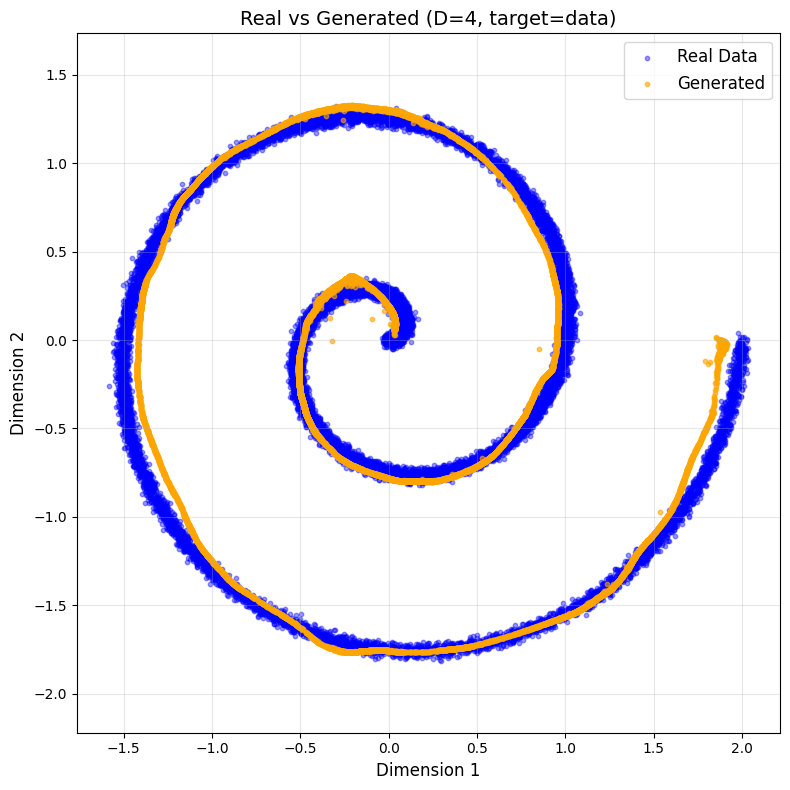


=== Training D=4, target=v ===
Data std: 0.5774
Using sigma: 0.1925
Data shape: torch.Size([20000, 4])


Training D=4, target=v:   0%|          | 1/500 [00:00<02:12,  3.78it/s]

[D=4] Epoch 1/500 | v-prediction loss: 3.8655


Training D=4, target=v:  10%|█         | 50/500 [00:12<01:55,  3.91it/s]

[D=4] Epoch 50/500 | v-prediction loss: 1.8005


Training D=4, target=v:  20%|██        | 100/500 [00:25<01:39,  4.02it/s]

[D=4] Epoch 100/500 | v-prediction loss: 1.8888


Training D=4, target=v:  30%|███       | 150/500 [00:38<01:32,  3.79it/s]

[D=4] Epoch 150/500 | v-prediction loss: 1.6254


Training D=4, target=v:  40%|████      | 200/500 [00:50<01:25,  3.53it/s]

[D=4] Epoch 200/500 | v-prediction loss: 1.7395


Training D=4, target=v:  50%|█████     | 250/500 [01:10<03:12,  1.30it/s]

[D=4] Epoch 250/500 | v-prediction loss: 1.5992


Training D=4, target=v:  60%|██████    | 300/500 [01:33<02:28,  1.35it/s]

[D=4] Epoch 300/500 | v-prediction loss: 1.5585


Training D=4, target=v:  70%|███████   | 350/500 [01:58<00:47,  3.19it/s]

[D=4] Epoch 350/500 | v-prediction loss: 1.4308


Training D=4, target=v:  80%|████████  | 400/500 [02:19<00:34,  2.88it/s]

[D=4] Epoch 400/500 | v-prediction loss: 1.4672


Training D=4, target=v:  90%|█████████ | 450/500 [02:46<00:27,  1.84it/s]

[D=4] Epoch 450/500 | v-prediction loss: 1.4228


Training D=4, target=v: 100%|██████████| 500/500 [03:09<00:00,  2.63it/s]

[D=4] Epoch 500/500 | v-prediction loss: 1.6477
Sampling with async schedule:
  D=4, M=100, steps=100
  Target type: v
  Generating 20000 samples


Sampling complete!


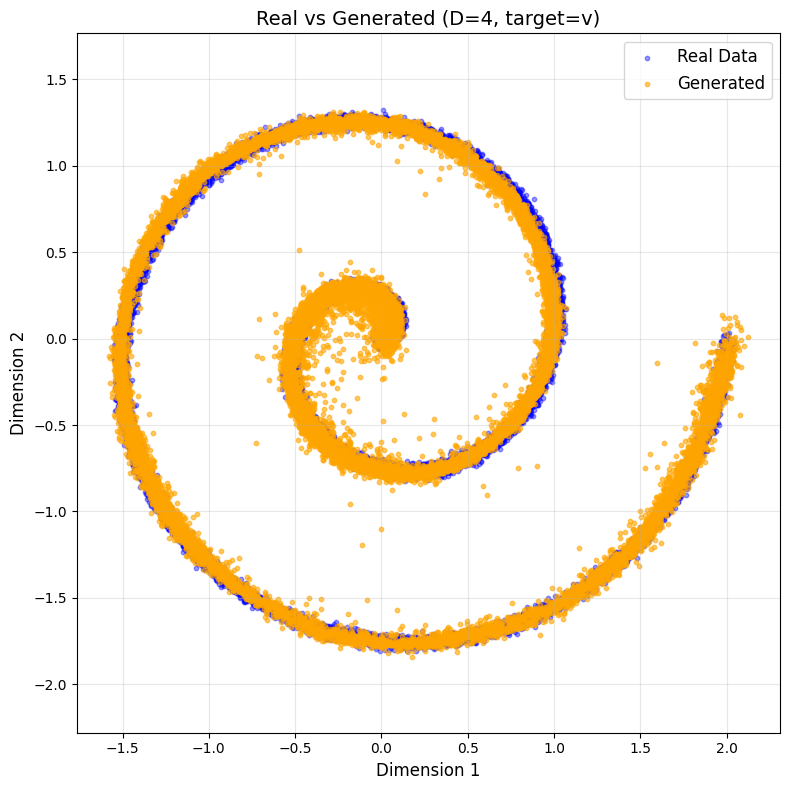


=== Training D=16, target=data ===
Data std: 0.2888
Using sigma: 0.0963
Data shape: torch.Size([20000, 16])


Training D=16, target=data:   0%|          | 1/500 [00:00<02:37,  3.16it/s]

[D=16] Epoch 1/500 | data-prediction loss: 1.1412


Training D=16, target=data:  10%|█         | 50/500 [00:23<05:30,  1.36it/s]

[D=16] Epoch 50/500 | data-prediction loss: 0.0896


Training D=16, target=data:  20%|██        | 100/500 [00:46<03:57,  1.68it/s]

[D=16] Epoch 100/500 | data-prediction loss: 0.0781


Training D=16, target=data:  30%|███       | 150/500 [01:30<05:16,  1.11it/s]

[D=16] Epoch 150/500 | data-prediction loss: 0.0656


Training D=16, target=data:  40%|████      | 200/500 [02:08<01:50,  2.71it/s]

[D=16] Epoch 200/500 | data-prediction loss: 0.0560


Training D=16, target=data:  50%|█████     | 250/500 [02:27<01:18,  3.17it/s]

[D=16] Epoch 250/500 | data-prediction loss: 0.0457


Training D=16, target=data:  60%|██████    | 300/500 [02:45<01:03,  3.14it/s]

[D=16] Epoch 300/500 | data-prediction loss: 0.0391


Training D=16, target=data:  70%|███████   | 350/500 [03:02<00:48,  3.09it/s]

[D=16] Epoch 350/500 | data-prediction loss: 0.0401


Training D=16, target=data:  80%|████████  | 400/500 [03:22<00:40,  2.48it/s]

[D=16] Epoch 400/500 | data-prediction loss: 0.0285


Training D=16, target=data:  90%|█████████ | 450/500 [03:40<00:16,  3.09it/s]

[D=16] Epoch 450/500 | data-prediction loss: 0.0320


Training D=16, target=data: 100%|██████████| 500/500 [03:56<00:00,  2.11it/s]

[D=16] Epoch 500/500 | data-prediction loss: 0.0318
Sampling with async schedule:
  D=16, M=100, steps=100
  Target type: data
  Generating 20000 samples


Sampling complete!


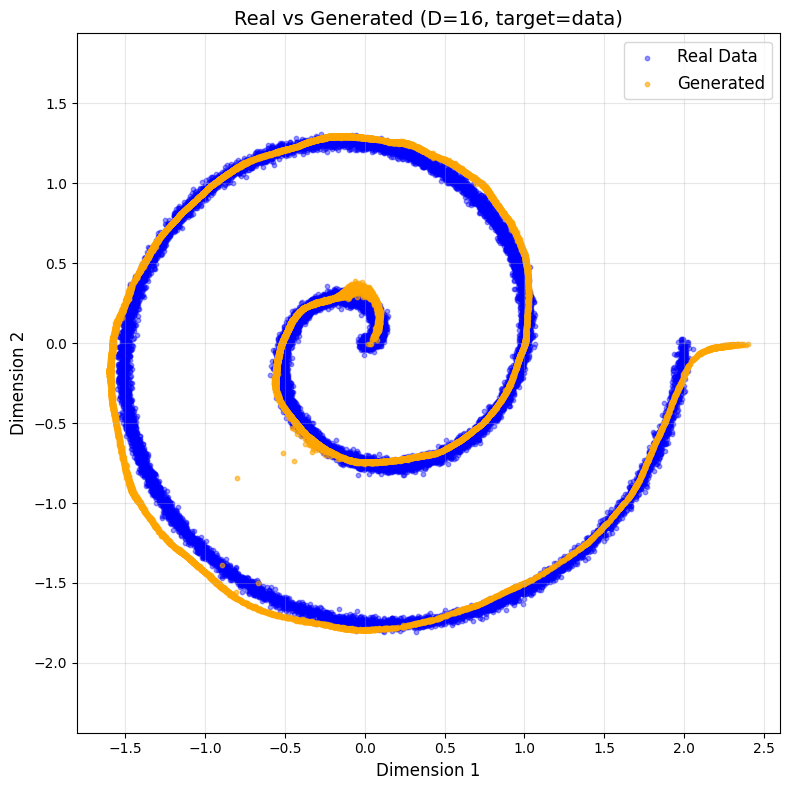


=== Training D=16, target=v ===
Data std: 0.2887
Using sigma: 0.0962
Data shape: torch.Size([20000, 16])


Training D=16, target=v:   0%|          | 1/500 [00:00<03:31,  2.36it/s]

[D=16] Epoch 1/500 | v-prediction loss: 2.4892


Training D=16, target=v:  10%|█         | 50/500 [00:15<02:15,  3.32it/s]

[D=16] Epoch 50/500 | v-prediction loss: 0.8105


Training D=16, target=v:  20%|██        | 100/500 [00:30<01:55,  3.47it/s]

[D=16] Epoch 100/500 | v-prediction loss: 0.5813


Training D=16, target=v:  30%|███       | 150/500 [00:46<02:15,  2.58it/s]

[D=16] Epoch 150/500 | v-prediction loss: 0.4893


Training D=16, target=v:  40%|████      | 200/500 [01:02<01:26,  3.48it/s]

[D=16] Epoch 200/500 | v-prediction loss: 0.4347


Training D=16, target=v:  50%|█████     | 250/500 [01:27<02:09,  1.93it/s]

[D=16] Epoch 250/500 | v-prediction loss: 0.4162


Training D=16, target=v:  60%|██████    | 300/500 [01:48<01:22,  2.42it/s]

[D=16] Epoch 300/500 | v-prediction loss: 0.3622


Training D=16, target=v:  70%|███████   | 350/500 [02:03<00:45,  3.33it/s]

[D=16] Epoch 350/500 | v-prediction loss: 0.3390


Training D=16, target=v:  80%|████████  | 400/500 [02:18<00:29,  3.43it/s]

[D=16] Epoch 400/500 | v-prediction loss: 0.3384


Training D=16, target=v:  90%|█████████ | 450/500 [02:33<00:14,  3.37it/s]

[D=16] Epoch 450/500 | v-prediction loss: 0.3102


Training D=16, target=v: 100%|██████████| 500/500 [02:49<00:00,  2.94it/s]

[D=16] Epoch 500/500 | v-prediction loss: 0.2964
Sampling with async schedule:
  D=16, M=100, steps=100
  Target type: v
  Generating 20000 samples


Sampling complete!


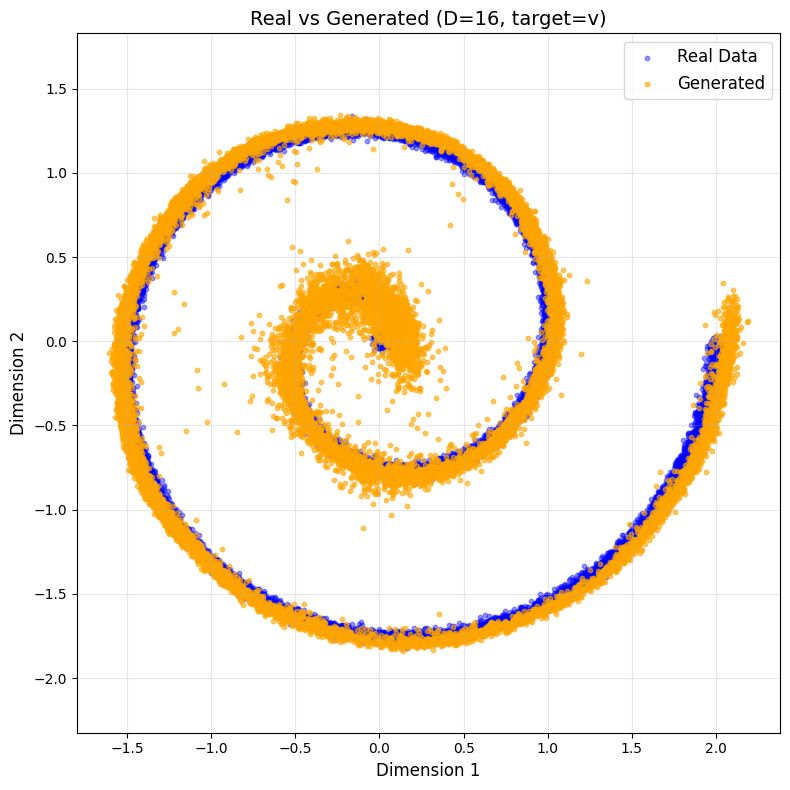


=== Training D=512, target=data ===
Data std: 0.0511
Using sigma: 0.0170
Data shape: torch.Size([20000, 512])


Training D=512, target=data:   0%|          | 1/500 [00:00<05:11,  1.60it/s]

[D=512] Epoch 1/500 | data-prediction loss: 0.8012


Training D=512, target=data:  10%|█         | 50/500 [00:46<05:46,  1.30it/s]

[D=512] Epoch 50/500 | data-prediction loss: 0.0190


Training D=512, target=data:  20%|██        | 100/500 [01:25<04:53,  1.36it/s]

[D=512] Epoch 100/500 | data-prediction loss: 0.0162


Training D=512, target=data:  30%|███       | 150/500 [02:02<04:04,  1.43it/s]

[D=512] Epoch 150/500 | data-prediction loss: 0.0153


Training D=512, target=data:  40%|████      | 200/500 [02:37<03:31,  1.42it/s]

[D=512] Epoch 200/500 | data-prediction loss: 0.0114


Training D=512, target=data:  50%|█████     | 250/500 [03:12<02:48,  1.49it/s]

[D=512] Epoch 250/500 | data-prediction loss: 0.0100


Training D=512, target=data:  60%|██████    | 300/500 [03:47<02:16,  1.46it/s]

[D=512] Epoch 300/500 | data-prediction loss: 0.0099


Training D=512, target=data:  70%|███████   | 350/500 [04:22<01:41,  1.48it/s]

[D=512] Epoch 350/500 | data-prediction loss: 0.0094


Training D=512, target=data:  80%|████████  | 400/500 [04:57<01:10,  1.42it/s]

[D=512] Epoch 400/500 | data-prediction loss: 0.0063


Training D=512, target=data:  90%|█████████ | 450/500 [05:32<00:33,  1.51it/s]

[D=512] Epoch 450/500 | data-prediction loss: 0.0065


Training D=512, target=data: 100%|██████████| 500/500 [06:10<00:00,  1.35it/s]

[D=512] Epoch 500/500 | data-prediction loss: 0.0062
Sampling with async schedule:
  D=512, M=100, steps=100
  Target type: data
  Generating 20000 samples


Sampling complete!


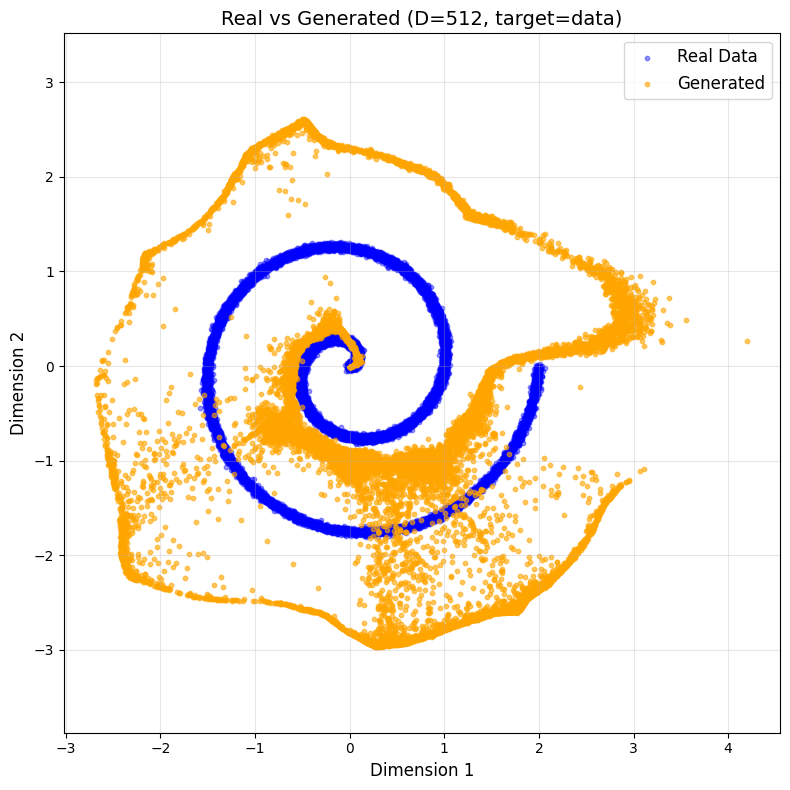


=== Training D=512, target=v ===
Data std: 0.0511
Using sigma: 0.0170
Data shape: torch.Size([20000, 512])


Training D=512, target=v:   0%|          | 1/500 [00:00<06:20,  1.31it/s]

[D=512] Epoch 1/500 | v-prediction loss: 2.0142


Training D=512, target=v:  10%|█         | 50/500 [00:43<05:22,  1.40it/s]

[D=512] Epoch 50/500 | v-prediction loss: 1.0253


Training D=512, target=v:  20%|██        | 100/500 [01:17<04:47,  1.39it/s]

[D=512] Epoch 100/500 | v-prediction loss: 1.0264


Training D=512, target=v:  30%|███       | 150/500 [01:50<03:55,  1.49it/s]

[D=512] Epoch 150/500 | v-prediction loss: 1.0163


Training D=512, target=v:  40%|████      | 200/500 [02:24<03:22,  1.48it/s]

[D=512] Epoch 200/500 | v-prediction loss: 1.0174


Training D=512, target=v:  50%|█████     | 250/500 [03:00<04:12,  1.01s/it]

[D=512] Epoch 250/500 | v-prediction loss: 1.0133


Training D=512, target=v:  60%|██████    | 300/500 [03:53<03:48,  1.14s/it]

[D=512] Epoch 300/500 | v-prediction loss: 1.0111


Training D=512, target=v:  70%|███████   | 350/500 [04:44<02:18,  1.08it/s]

[D=512] Epoch 350/500 | v-prediction loss: 1.0003


Training D=512, target=v:  80%|████████  | 400/500 [05:18<01:12,  1.38it/s]

[D=512] Epoch 400/500 | v-prediction loss: 0.9976


Training D=512, target=v:  90%|█████████ | 450/500 [05:51<00:32,  1.56it/s]

[D=512] Epoch 450/500 | v-prediction loss: 0.9914


Training D=512, target=v: 100%|██████████| 500/500 [06:25<00:00,  1.30it/s]

[D=512] Epoch 500/500 | v-prediction loss: 0.9888
Sampling with async schedule:
  D=512, M=100, steps=100
  Target type: v
  Generating 20000 samples


Sampling complete!


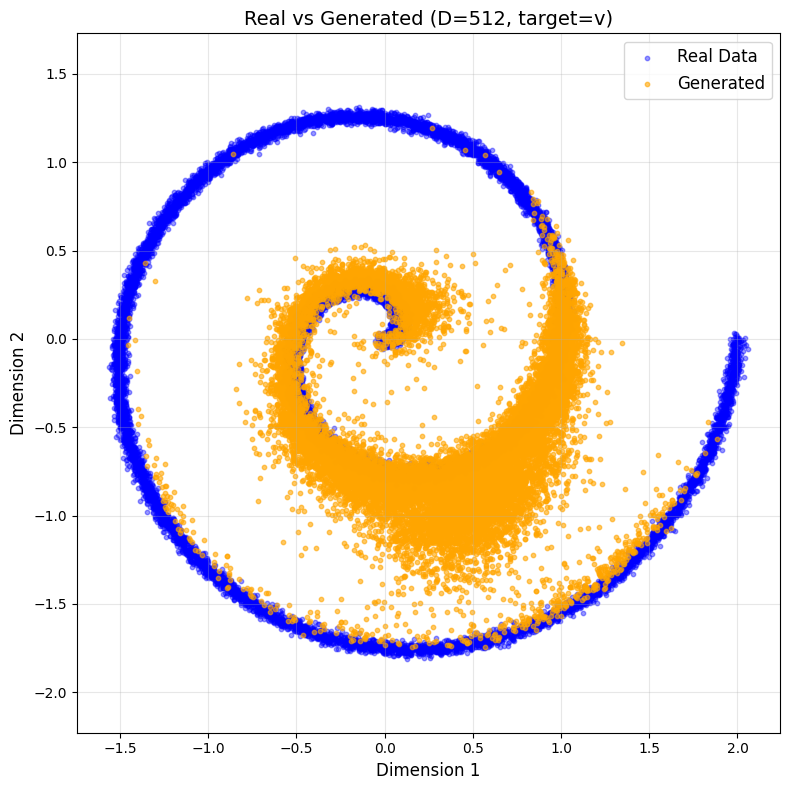

In [6]:
Ds = [4, 16, 512]
target_types = ["data", "v"]

for D in Ds:
    for tt in target_types:
        print(f"\n=== Training D={D}, target={tt} ===")
        model, P, x_hat, x, sigma = train_toy(
            D=D,
            d=2,
            target_type=tt,
            n_samples=20000,
            batch_size=1024,
            epochs=500,
            lr=1e-3,
        )
        visualize_2d(model, P, n_points=20000, target_type=tt, steps=100, x_true=x_hat, sigma=sigma)

# 2 Calculating the loss.

Now we calculate the loss and look at the gradient. We look at the loss value for different $t$ (it is a scalar now).



# 2.1 target predicting data.

In [7]:
model, P, x_hat, x, sigma = train_toy(
    D=4,
    d=2,
    target_type="data",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
)

Data std: 0.5772
Using sigma: 0.1924
Data shape: torch.Size([20000, 4])


Training D=4, target=data:   0%|          | 1/500 [00:00<03:45,  2.22it/s]

[D=4] Epoch 1/500 | data-prediction loss: 2.1720


Training D=4, target=data:  10%|█         | 50/500 [00:18<02:18,  3.25it/s]

[D=4] Epoch 50/500 | data-prediction loss: 0.7519


Training D=4, target=data:  20%|██        | 100/500 [00:35<02:53,  2.31it/s]

[D=4] Epoch 100/500 | data-prediction loss: 0.8183


Training D=4, target=data:  30%|███       | 150/500 [00:51<01:49,  3.21it/s]

[D=4] Epoch 150/500 | data-prediction loss: 0.6639


Training D=4, target=data:  40%|████      | 200/500 [01:07<01:32,  3.26it/s]

[D=4] Epoch 200/500 | data-prediction loss: 0.7223


Training D=4, target=data:  50%|█████     | 250/500 [01:24<01:14,  3.35it/s]

[D=4] Epoch 250/500 | data-prediction loss: 0.6163


Training D=4, target=data:  60%|██████    | 300/500 [01:42<01:05,  3.07it/s]

[D=4] Epoch 300/500 | data-prediction loss: 0.5867


Training D=4, target=data:  70%|███████   | 350/500 [01:58<00:58,  2.56it/s]

[D=4] Epoch 350/500 | data-prediction loss: 0.6500


Training D=4, target=data:  80%|████████  | 400/500 [02:14<00:30,  3.26it/s]

[D=4] Epoch 400/500 | data-prediction loss: 0.5887


Training D=4, target=data:  90%|█████████ | 450/500 [02:30<00:18,  2.73it/s]

[D=4] Epoch 450/500 | data-prediction loss: 0.5626


Training D=4, target=data: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]

[D=4] Epoch 500/500 | data-prediction loss: 0.7003


In [8]:
N = 50
losses = []
grads = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t_torch = torch.tensor(t_scalar, requires_grad=True)
    t = t_torch.expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1 - x_0
    loss = ((v_target - model_pred) ** 2).mean()
    loss2 = torch.clone(loss)
    losses.append(loss2.detach().numpy())
    loss.backward()
    grads.append(t_torch.grad.detach().numpy())

We look at the loss and grad value for different $t$ (it is a scalar now)

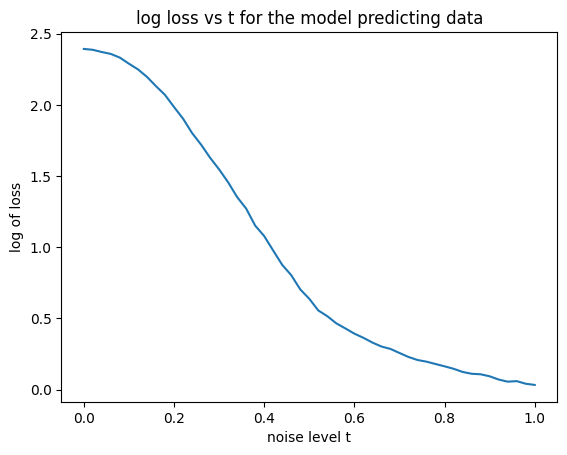

In [9]:
from matplotlib import pyplot as plt
import math
plt.title("log loss vs t for the model predicting data")
plt.xlabel("noise level t")
plt.ylabel("log of loss")
plt.plot([i/N for i in range(N+1)], [np.log(loss) for loss in losses])
plt.savefig("illustration/losses_vs_t_data.png")

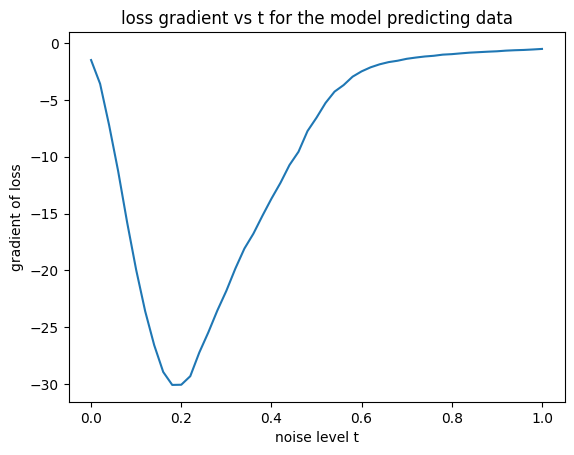

In [10]:
from matplotlib import pyplot as plt
import math
plt.title("loss gradient vs t for the model predicting data")
plt.xlabel("noise level t")
plt.ylabel("gradient of loss")
plt.plot([i/N for i in range(N+1)], grads)
plt.savefig("illustration/grads_vs_t_data.png")

# 2.2 Target predicting v

In [11]:
model, P, x_hat, x, sigma = train_toy(
    D=4,
    d=2,
    target_type="v",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
)

Data std: 0.5767
Using sigma: 0.1922
Data shape: torch.Size([20000, 4])


Training D=4, target=v:   0%|          | 1/500 [00:00<03:32,  2.35it/s]

[D=4] Epoch 1/500 | v-prediction loss: 3.8358


Training D=4, target=v:  10%|█         | 50/500 [00:16<02:52,  2.60it/s]

[D=4] Epoch 50/500 | v-prediction loss: 1.8697


Training D=4, target=v:  20%|██        | 100/500 [00:32<02:37,  2.53it/s]

[D=4] Epoch 100/500 | v-prediction loss: 1.6434


Training D=4, target=v:  30%|███       | 150/500 [00:59<02:21,  2.48it/s]

[D=4] Epoch 150/500 | v-prediction loss: 1.5197


Training D=4, target=v:  40%|████      | 200/500 [01:15<01:35,  3.14it/s]

[D=4] Epoch 200/500 | v-prediction loss: 1.6279


Training D=4, target=v:  50%|█████     | 250/500 [01:32<01:47,  2.33it/s]

[D=4] Epoch 250/500 | v-prediction loss: 1.4895


Training D=4, target=v:  60%|██████    | 300/500 [01:50<00:59,  3.35it/s]

[D=4] Epoch 300/500 | v-prediction loss: 1.4639


Training D=4, target=v:  70%|███████   | 350/500 [02:06<00:44,  3.35it/s]

[D=4] Epoch 350/500 | v-prediction loss: 1.6211


Training D=4, target=v:  80%|████████  | 400/500 [02:22<00:30,  3.32it/s]

[D=4] Epoch 400/500 | v-prediction loss: 1.4055


Training D=4, target=v:  90%|█████████ | 450/500 [02:39<00:15,  3.28it/s]

[D=4] Epoch 450/500 | v-prediction loss: 1.6557


Training D=4, target=v: 100%|██████████| 500/500 [02:55<00:00,  2.85it/s]

[D=4] Epoch 500/500 | v-prediction loss: 1.4262


In [12]:
N = 50
losses = []
grads = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t_torch = torch.tensor(t_scalar, requires_grad=True)
    t = t_torch.expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1 - x_0
    loss = ((v_target - model_pred) ** 2).mean()
    loss2 = torch.clone(loss)
    losses.append(loss2.detach().numpy())
    loss.backward()
    grads.append(t_torch.grad.detach().numpy())

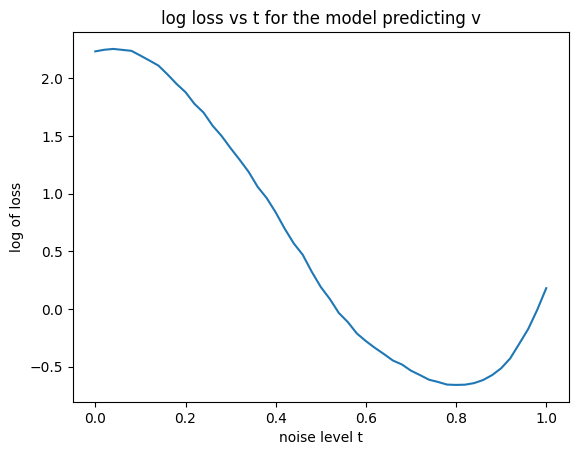

In [13]:
from matplotlib import pyplot as plt
import math
plt.title("log loss vs t for the model predicting v")
plt.xlabel("noise level t")
plt.ylabel("log of loss")
plt.plot([i/N for i in range(N+1)], [np.log(loss) for loss in losses])
plt.savefig("illustration/losses_vs_t_v.png")

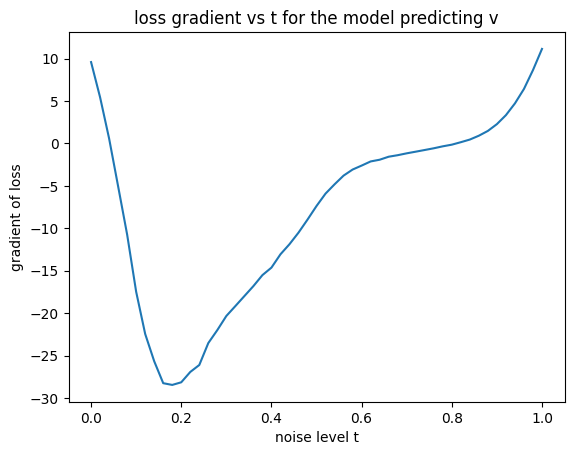

In [14]:
from matplotlib import pyplot as plt
import math
plt.title("loss gradient vs t for the model predicting v")
plt.xlabel("noise level t")
plt.ylabel("gradient of loss")
plt.plot([i/N for i in range(N+1)], grads)
plt.savefig("illustration/grads_vs_t_data.png")

# 3 Learning and optimizing the schedule

Now we are going to minimize the target function if we are predicting $h(X_t, t) = \mathbb E[X_1|X_t, t]$, we should minimize

$$\int_{t} \sum_{j}\frac{t_j\mathrm dt_j}{(1-t_j)^3}\mathbb E[(h(X_t,t)-\mathbb E[X_1|X_t,t])^2].$$

We use a discretizaion to calculate the this interval. That is, if out noise schedure is $t_{j,T}$, we calculate
$$L(t)=\sum_T \sum_{j}\frac{(t_{j,T}-t_{j,T-1})\cdot t_{j,T}}{(1-t_{j,T})^3}\mathbb E[(h(X_t,t)-\mathbb E[X_1|X_t,t])]^2.$$

In practice, when we have $N$ samples, we do the following:
$$L(t)=\sum_T \sum_{j}\frac{(t_{j,T}-t_{j,T-1})\cdot t_{j,T}}{\color{red}(1-t_{j,T})^3}\cdot \frac{1}{N}\sum_{s=1}^N (h(X_t^{(s)},t)-X_1^{(s)})^2.$$

Similarly, if we are predicting the speed, i.e., $h(X_t,t)=\mathbb E[X_1-X_0|X_t, t]$, the weight for the $L(T)$ should be (the weight is different)

$$L(t)=\sum_T \sum_{j}\frac{(t_{j,T}-t_{j,T-1})\cdot t_{j,T}}{\color{red}{1-t_{j,T}}}\cdot \frac{1}{N}\sum_{s=1}^N (h(X_t^{(s)},t)-X_1^{(s)})^2.$$


The per-dim noise schedule is $t\in\mathbb R^{(M+1)\times d}$, where $d$ is the number dimension of the data and $M$ is the step. The noise schedule $t$ initially are given by linear: $t_{i}$ is a all $i/M$ vector for $i=0,1,\dots,N$. We want the following holds during the training process:

- For any $0\le i\le M$, the total sum of $t_i$ is $i\cdot d/M$. Specifically, $t_0$ is an all-zero vector and $t_1$ is all-one vector.

We do **NOT** have a good idea for splitting the intervals. We just use the uniform splitting here.

- For any $1\le i\le M-1$ and $1\le j\le d$, $t_{i-1,j}\le t_{i,j}\le t_{i+1,j}$.

Our algorithm is as follows:

- Calculate $L(T)=\sum_i \sum_{j}\frac{(t_{i,j}-t_{i-1,j})\cdot t_{i,j}}{(1-t_{i,j})^3}\cdot\frac{1}{N}\sum_{s=1}^N(h_j(X_t^{(s)},t)-{X_t^{(s)}}_j)^2.$ Here, $X^{(s)}$ denotes the $s$th sample. Since we are NOT using the same noise level per dimension, for $j$th dimension, it is given as $X_j = (1-t_{i,j}) \mathcal N(0,1) + t_{i,j} {X_1}_j$ be the noisy sample with noise level (per dimension) $t_{i,j}$. You can choose the random $\mathcal N(0,1)$ to be fixed or not fixed during the training process.
- Looping the followings for $n$ epochs:
- - For each odd number $i$ (it can be done in batch), the gradient of $g_i = \partial L/\partial t_{i}$. $g_i'$ is the vector projecting $g_i$ to the hyperplane $t_{i,1}+\dots+t_{i,d}=0$. Then, we update this noise level by a gradient descent: $t_i' = t_i -\lambda \cdot g_i$, then clamp every coordinate monotonically: $t_{i-1,j}\le t_{i,j}\le t_{i+1,j}$. Here, $\lambda$ is the learning rate.
- - For each even number $i$, do the same.

Then you can get an updated $t$.

## 3.1 Observe the visualization when targeting data

In [49]:
def compute_weight(t, dt, target_type, eps=1e-3):
    """
    calculate the weight for integral.

    :param t: noise schedule (D,)
    :param dt: difference of noise schedule (D,)
    :param target_type: "data" or "v"
    :param eps: a small number to prevert division of zero
    :return: the weight (D,)
    """
    clamped_1mt = torch.clamp(1.-t, min = eps)
    if target_type == "data":
        # for X_1: weight = t / (1-t)^3
        weight = dt * t / (clamped_1mt ** 3)
    elif target_type == "v":
        # for velocity: weight = t / (1-t)
        weight = dt * t / clamped_1mt
    else:
        raise ValueError(f"Unknown target_type: {target_type}")

    return weight

def total_loss(x_1, t, model, target_type="data", x_0=None,
                    eps=1e-3, safe_ratio=1.0, weight_max_cap = 10.0, weight_min_cap = 0.1):
    """
    Calculate the Girsanov loss

    :param target_type: "data" or "v"
    """
    N, D = x_1.shape
    M = t.shape[1] - 1

    if x_0 is None:
        x_0 = torch.randn_like(x_1)

    total = 0.0
    max_i = int(safe_ratio * M)

    for i in range(1, max_i):
        t_i = t[:, i]
        t_i_prev = t[:, i-1]

        t_expanded = t_i.unsqueeze(0).expand(N, D)
        x_t = t_expanded * x_1 + (1 - t_expanded) * x_0

        with torch.no_grad():
            pred = model(x_t, t_expanded)

        # using target_type to calculate MSE
        if target_type == "data":
            # for X_1
            mse_per_dim = ((pred - x_1) ** 2).mean(dim=0)
        elif target_type == "v":
            # for velocity.
            # In rectified flow，v = X_1 - X_0
            true_v = x_1 - x_0
            mse_per_dim = ((pred - true_v) ** 2).mean(dim=0)

        dt = t_i - t_i_prev

        # calculating the weight using target_type
        weight = compute_weight(t_i, dt, target_type, eps)
        weight = torch.clamp(weight, max = weight_max_cap, min = weight_min_cap)

        total += (mse_per_dim * weight).sum()

    return total


def project_gradient_to_hyperplane(grad):
    return grad - grad.mean()


def grad_update(x_0, x_1, t, model, target_type, parity,
                learning_rate=0.1, eps=1e-3, safe_ratio=1.0,
                weight_max_cap = 10, weight_min_cap = 0.1):
    N, D = x_1.shape
    M = t.shape[1] - 1
    t_new = t.clone()

    max_idx = int(safe_ratio * M)

    if parity == 0:
        indices = list(range(2, max_idx, 2))
    else:
        indices = list(range(1, max_idx, 2))

    if len(indices) == 0:
        return t_new

    for idx in indices:
        t_var = t[:, idx].clone().detach().requires_grad_(True)
        t_i_prev = t[:, idx - 1]

        t_expanded = t_var.unsqueeze(0).expand(N, D)
        x_t = t_expanded * x_1 + (1 - t_expanded) * x_0

        pred = model(x_t, t_expanded)

        # from target_type calculate MSE
        if target_type == "data":
            mse_per_dim = ((pred - x_1) ** 2).mean(dim=0)
        elif target_type == "v":
            true_v = x_1 - x_0
            mse_per_dim = ((pred - true_v) ** 2).mean(dim=0)

        dt = t_var - t_i_prev

        # from target_type calculate weight
        weight = compute_weight(t_var, dt, target_type, eps)
        weight = torch.clamp(weight, max=weight_max_cap, min = weight_min_cap)

        loss = (mse_per_dim * weight).sum()
        loss.backward()

        grad = t_var.grad
        grad_projected = project_gradient_to_hyperplane(grad)

        with torch.no_grad():
            t_new[:, idx] = t_var - learning_rate * grad_projected

            current_sum = t_new[:, idx].sum()
            target_sum = idx * D / M
            correction = (target_sum - current_sum) / D
            t_new[:, idx] = t_new[:, idx] + correction

            if idx > 0:
                t_new[:, idx] = torch.maximum(t_new[:, idx], t_new[:, idx-1] + 1e-4)
            if idx < M:
                t_new[:, idx] = torch.minimum(t_new[:, idx], t_new[:, idx+1] - 1e-4)

    return t_new


def learning(x_1, M, model, target_type="data", epoch=100,
                  learning_rate=0.1, fixed_x0=True, eps=1e-3,
                  subsample=2000, loss_freq=10, safe_ratio=1.0,
                  weight_max_cap = 10.0, weight_min_cap = 0.1,
                  t_initial = None):
    """
    A safe optimizing for the schedule. Can do both target_type
    It is quicker.
    :param x_1: true data
    :param M: number of steps. Notice that the output is tensor of shape (D, M+1)!
    :param target_type: "data" or "v"
    :param fixed_x0: bool, check whether x_0 is using the fixed one throughout the learning process
    :param eps: float, still to eliminate division by zero
    :param subsample: int, subsample the data
    :param loss_freq: int, how often to compute loss
    :param safe_ratio: float, to get rid of exploding of the gradient, we don't update the data when we update the last (1-safe_ratio) portion of data.
    :param t_initial: float, initial schedule
    """
    N_samples, D = x_1.shape


    if subsample is not None and subsample < N_samples:
        indices = torch.randperm(N_samples)[:subsample]
        x_1_sub = x_1[indices]
        print(f"Using {subsample}/{N_samples} samples for optimization")
    else:
        x_1_sub = x_1
        subsample = N_samples

    if t_initial is None:
        t = torch.zeros(D, M + 1, device=x_1.device)
        for i in range(M + 1):
            t[:, i] = i / M
    else:
        t = t_initial
        assert t_initial.shape[1] == M+1

    if fixed_x0:
        x_0 = torch.randn_like(x_1_sub)
    else:
        x_0 = None

    loss_history = []

    print(f"Target type: {target_type}")
    if target_type == "data":
        print(f"  Model predicts: X_1")
        print(f"  Weight formula: t / (1-t)³")
    elif target_type == "v":
        print(f"  Model predicts: velocity v")
        print(f"  Weight formula: t / (1-t)")

    print(f"Schedule shape: {t.shape} (D={D}, M={M})")
    print(f"Safe ratio: {safe_ratio} (optimizing only first {int(safe_ratio*M)}/{M} steps)")
    print(f"Loss frequency: every {loss_freq} epochs")

    initial_loss = total_loss(x_1_sub, t, model, target_type, x_0, eps, safe_ratio)
    print(f"Initial loss: {initial_loss.item():.6f}\n")
    loss_history.append(initial_loss.item())

    for ep in tqdm(range(epoch), desc="Optimizing"):
        if not fixed_x0:
            x_0 = torch.randn_like(x_1_sub)

        parity = 1 - (ep % 2)
        t = grad_update(x_0, x_1_sub, t, model, target_type, parity,
                            learning_rate, eps, safe_ratio, weight_max_cap, weight_min_cap)

        if (ep + 1) % loss_freq == 0 or ep == epoch - 1:
            current_loss = total_loss(x_1_sub, t, model, target_type,
                                          x_0, eps, safe_ratio)
            loss_history.append(current_loss.item())

            step_type = "odd" if parity == 1 else "even"
            print(f"Epoch {ep + 1}/{epoch} ({step_type}) | Loss: {current_loss.item():.6f}")

    if subsample < N_samples:
        x_0_full = torch.randn_like(x_1) if fixed_x0 else None
        final_loss_full = total_loss(x_1, t, model, target_type,
                                         x_0_full, eps, safe_ratio, weight_max_cap, weight_min_cap)
        print(f"\nFinal loss (full {N_samples} samples): {final_loss_full.item():.6f}")

    print(f"Final loss (subsample): {loss_history[-1]:.6f}")
    print(f"Sum constraints: {[t[:, i].sum().item() for i in [0, M//2, M]]}")

    # 可视化
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs_with_loss = [0] + [i * loss_freq for i in range(1, len(loss_history) - 1)] + [epoch]
    axes[0].plot(epochs_with_loss[:len(loss_history)], loss_history, 'o-')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Optimization Progress (target={target_type})')
    axes[0].grid(True)

    im = axes[1].imshow(t.cpu().numpy(), aspect='auto', cmap='viridis')
    axes[1].set_xlabel('Time step')
    axes[1].set_ylabel('Dimension')
    axes[1].set_title('Optimized Schedule')
    axes[1].axvline(x=int(safe_ratio*M), color='red', linestyle='--',
                    linewidth=2, label=f'Safe boundary')
    axes[1].legend()
    plt.colorbar(im, ax=axes[1])

    for d in range(min(5, D)):
        axes[2].plot(t[d].cpu().numpy(), 'o-', label=f'Dim {d}', alpha=0.7)
    mean_schedule = np.array([i * D / M for i in range(M + 1)]) / D
    axes[2].plot(mean_schedule, 'k--', linewidth=2, label='Mean')
    axes[2].axvline(x=int(safe_ratio*M), color='red', linestyle='--',
                    linewidth=2, alpha=0.5)
    axes[2].set_xlabel('Step')
    axes[2].set_ylabel('t value')
    axes[2].set_title('Per-dimension Schedules')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(f'illustration/schedule_{target_type}.png', dpi=150)
    plt.close()

    return t, loss_history



In [35]:
def compare_schedules(model, P, t_optimized, x_true, sigma, t_uniform=None,
                     n_points=2000, target_type="data", steps=250):
    """
    compare the result of the uniform schedule and the optimized schedule

    :param t_uniform: uniform schedule (D, M+1)，all the dimensions are [0, 1/M, 2/M, ..., 1]
    :param t_optimized: optimized schedule (D, M+1)
    """
    print("=" * 60)
    print("sampling - uniform Schedule")
    print("=" * 60)
    if t_uniform is None:
        D = t_optimized.shape[0]
        M = t_optimized.shape[1]-1
        t_uniform = torch.tensor([[i/M for i in range(M+1)] for _ in range(D)], device=device)

    # uniform schedule
    x_uniform = visualize_2d(
        model, P, t_uniform,
        n_points=n_points, target_type=target_type,
        steps=steps, x_true=x_true, sigma=sigma
    )

    print("\n" + "=" * 60)
    print("sampling - optimized Schedule")
    print("=" * 60)

    # optimized schedule
    x_optimized = visualize_2d(
        model, P, t_optimized,
        n_points=n_points, target_type=target_type,
        steps=steps, x_true=x_true, sigma=sigma
    )

    # comparing in alignment
    pred_uniform_2d = (x_uniform @ P).cpu().numpy()
    pred_optimized_2d = (x_optimized @ P).cpu().numpy()
    x_true_np = x_true.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # real data
    axes[0].scatter(x_true_np[:, 0], x_true_np[:, 1], s=5, alpha=0.5)
    axes[0].set_title("True Data")
    axes[0].axis("equal")

    # uniform schedule
    axes[1].scatter(pred_uniform_2d[:, 0], pred_uniform_2d[:, 1], s=5, alpha=0.5)
    axes[1].set_title("Default Schedule")
    axes[1].axis("equal")

    # optimized schedule
    axes[2].scatter(pred_optimized_2d[:, 0], pred_optimized_2d[:, 1], s=5, alpha=0.5)
    axes[2].set_title("Optimized Schedule")
    axes[2].axis("equal")

    plt.tight_layout()
    plt.savefig(f"illustration/comparison_uniform_vs_optimized_target_{target_type}.png", dpi=200)
    plt.show()

In [57]:
# ========== Usage of predicting data ==========
model_data, P, x_hat, x, sigma = train_toy(
    D=32, d=2, target_type="data",
    n_samples=10000, batch_size=1024,
    epochs=500, lr=1e-3
)

x_1 = x / sigma

Data std: 0.2041
Using sigma: 0.0680
Data shape: torch.Size([10000, 32])


Training D=32, target=data:   0%|          | 1/500 [00:00<01:33,  5.33it/s]

[D=32] Epoch 1/500 | data-prediction loss: 5.8250


Training D=32, target=data:  10%|█         | 51/500 [00:08<01:14,  6.05it/s]

[D=32] Epoch 50/500 | data-prediction loss: 0.1142


Training D=32, target=data:  20%|██        | 101/500 [00:16<01:01,  6.48it/s]

[D=32] Epoch 100/500 | data-prediction loss: 0.0780


Training D=32, target=data:  30%|███       | 151/500 [00:23<00:50,  6.91it/s]

[D=32] Epoch 150/500 | data-prediction loss: 0.0600


Training D=32, target=data:  40%|████      | 201/500 [00:31<00:44,  6.69it/s]

[D=32] Epoch 200/500 | data-prediction loss: 0.0448


Training D=32, target=data:  50%|█████     | 250/500 [00:39<00:48,  5.20it/s]

[D=32] Epoch 250/500 | data-prediction loss: 0.0388


Training D=32, target=data:  60%|██████    | 300/500 [00:48<00:36,  5.48it/s]

[D=32] Epoch 300/500 | data-prediction loss: 0.0373


Training D=32, target=data:  70%|███████   | 351/500 [00:57<00:25,  5.86it/s]

[D=32] Epoch 350/500 | data-prediction loss: 0.0315


Training D=32, target=data:  80%|████████  | 401/500 [01:07<00:22,  4.49it/s]

[D=32] Epoch 400/500 | data-prediction loss: 0.0514


Training D=32, target=data:  90%|█████████ | 451/500 [01:18<00:09,  5.29it/s]

[D=32] Epoch 450/500 | data-prediction loss: 0.0318


Training D=32, target=data: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]

[D=32] Epoch 500/500 | data-prediction loss: 0.0309


In [58]:
t_optimized, history = learning(
    x_1=x_1,
    M = 10,
    model=model_data,
    epoch=50,
    learning_rate=0.001,
    fixed_x0=True,
    subsample=5000,
    loss_freq=1,
    eps = 0.05,
    target_type = "data",
)

print("\n=== Checking Constraints ===")
D, M_plus_1 = t_optimized.shape
M = M_plus_1 - 1
for i in [0, M//2, M]:
    sum_i = t_optimized[:, i].sum().item()
    target = i * D / M
    print(f"Step {i}: sum={sum_i:.6f}, target={target:.6f}")


Using 5000/10000 samples for optimization
Target type: data
  Model predicts: X_1
  Weight formula: t / (1-t)³
Schedule shape: torch.Size([32, 11]) (D=32, M=10)
Safe ratio: 1.0 (optimizing only first 10/10 steps)
Loss frequency: every 1 epochs
Initial loss: 27.868557



Optimizing:   2%|▏         | 1/50 [00:02<01:51,  2.28s/it]

Epoch 1/50 (odd) | Loss: 27.468704


Optimizing:   4%|▍         | 2/50 [00:02<00:57,  1.20s/it]

Epoch 2/50 (even) | Loss: 27.432178


Optimizing:   6%|▌         | 3/50 [00:03<00:42,  1.11it/s]

Epoch 3/50 (odd) | Loss: 27.053684


Optimizing:   8%|▊         | 4/50 [00:03<00:34,  1.33it/s]

Epoch 4/50 (even) | Loss: 27.017988


Optimizing:  10%|█         | 5/50 [00:04<00:27,  1.62it/s]

Epoch 5/50 (odd) | Loss: 26.657845


Optimizing:  12%|█▏        | 6/50 [00:04<00:22,  1.94it/s]

Epoch 6/50 (even) | Loss: 26.623482


Optimizing:  14%|█▍        | 7/50 [00:04<00:19,  2.22it/s]

Epoch 7/50 (odd) | Loss: 26.281654


Optimizing:  16%|█▌        | 8/50 [00:05<00:16,  2.57it/s]

Epoch 8/50 (even) | Loss: 26.248362


Optimizing:  18%|█▊        | 9/50 [00:05<00:15,  2.72it/s]

Epoch 9/50 (odd) | Loss: 25.922724


Optimizing:  20%|██        | 10/50 [00:05<00:13,  2.94it/s]

Epoch 10/50 (even) | Loss: 25.890545


Optimizing:  22%|██▏       | 11/50 [00:05<00:12,  3.01it/s]

Epoch 11/50 (odd) | Loss: 25.579288


Optimizing:  24%|██▍       | 12/50 [00:06<00:11,  3.17it/s]

Epoch 12/50 (even) | Loss: 25.548048


Optimizing:  26%|██▌       | 13/50 [00:06<00:11,  3.16it/s]

Epoch 13/50 (odd) | Loss: 25.250580


Optimizing:  28%|██▊       | 14/50 [00:06<00:11,  3.23it/s]

Epoch 14/50 (even) | Loss: 25.216457


Optimizing:  30%|███       | 15/50 [00:07<00:11,  3.07it/s]

Epoch 15/50 (odd) | Loss: 24.932076


Optimizing:  32%|███▏      | 16/50 [00:07<00:11,  2.98it/s]

Epoch 16/50 (even) | Loss: 24.899075


Optimizing:  34%|███▍      | 17/50 [00:07<00:11,  2.92it/s]

Epoch 17/50 (odd) | Loss: 24.626247


Optimizing:  36%|███▌      | 18/50 [00:08<00:10,  3.11it/s]

Epoch 18/50 (even) | Loss: 24.594255


Optimizing:  38%|███▊      | 19/50 [00:08<00:10,  3.04it/s]

Epoch 19/50 (odd) | Loss: 24.332212


Optimizing:  40%|████      | 20/50 [00:08<00:10,  2.95it/s]

Epoch 20/50 (even) | Loss: 24.301149


Optimizing:  42%|████▏     | 21/50 [00:09<00:09,  2.94it/s]

Epoch 21/50 (odd) | Loss: 24.048738


Optimizing:  44%|████▍     | 22/50 [00:09<00:09,  2.91it/s]

Epoch 22/50 (even) | Loss: 24.018532


Optimizing:  46%|████▌     | 23/50 [00:10<00:09,  2.79it/s]

Epoch 23/50 (odd) | Loss: 23.774742


Optimizing:  48%|████▊     | 24/50 [00:10<00:08,  2.99it/s]

Epoch 24/50 (even) | Loss: 23.745346


Optimizing:  50%|█████     | 25/50 [00:10<00:08,  2.94it/s]

Epoch 25/50 (odd) | Loss: 23.511023


Optimizing:  52%|█████▏    | 26/50 [00:10<00:07,  3.10it/s]

Epoch 26/50 (even) | Loss: 23.482403


Optimizing:  54%|█████▍    | 27/50 [00:11<00:07,  3.09it/s]

Epoch 27/50 (odd) | Loss: 23.256897


Optimizing:  56%|█████▌    | 28/50 [00:11<00:07,  3.01it/s]

Epoch 28/50 (even) | Loss: 23.228966


Optimizing:  58%|█████▊    | 29/50 [00:11<00:07,  2.88it/s]

Epoch 29/50 (odd) | Loss: 23.011700


Optimizing:  60%|██████    | 30/50 [00:12<00:06,  2.99it/s]

Epoch 30/50 (even) | Loss: 22.984396


Optimizing:  62%|██████▏   | 31/50 [00:12<00:06,  2.97it/s]

Epoch 31/50 (odd) | Loss: 22.774624


Optimizing:  64%|██████▍   | 32/50 [00:12<00:05,  3.04it/s]

Epoch 32/50 (even) | Loss: 22.747906


Optimizing:  66%|██████▌   | 33/50 [00:13<00:05,  2.99it/s]

Epoch 33/50 (odd) | Loss: 22.545446


Optimizing:  68%|██████▊   | 34/50 [00:13<00:05,  3.16it/s]

Epoch 34/50 (even) | Loss: 22.519300


Optimizing:  70%|███████   | 35/50 [00:13<00:04,  3.17it/s]

Epoch 35/50 (odd) | Loss: 22.323444


Optimizing:  72%|███████▏  | 36/50 [00:14<00:04,  3.33it/s]

Epoch 36/50 (even) | Loss: 22.297815


Optimizing:  74%|███████▍  | 37/50 [00:14<00:03,  3.31it/s]

Epoch 37/50 (odd) | Loss: 22.108391


Optimizing:  76%|███████▌  | 38/50 [00:14<00:03,  3.42it/s]

Epoch 38/50 (even) | Loss: 22.083231


Optimizing:  78%|███████▊  | 39/50 [00:15<00:03,  3.34it/s]

Epoch 39/50 (odd) | Loss: 21.899464


Optimizing:  80%|████████  | 40/50 [00:15<00:03,  3.31it/s]

Epoch 40/50 (even) | Loss: 21.874722


Optimizing:  82%|████████▏ | 41/50 [00:15<00:02,  3.08it/s]

Epoch 41/50 (odd) | Loss: 21.696877


Optimizing:  84%|████████▍ | 42/50 [00:16<00:02,  3.00it/s]

Epoch 42/50 (even) | Loss: 21.672512


Optimizing:  86%|████████▌ | 43/50 [00:16<00:02,  2.91it/s]

Epoch 43/50 (odd) | Loss: 21.500065


Optimizing:  88%|████████▊ | 44/50 [00:16<00:02,  2.79it/s]

Epoch 44/50 (even) | Loss: 21.476118


Optimizing:  90%|█████████ | 45/50 [00:17<00:02,  2.14it/s]

Epoch 45/50 (odd) | Loss: 21.309227


Optimizing:  92%|█████████▏| 46/50 [00:18<00:02,  1.78it/s]

Epoch 46/50 (even) | Loss: 21.285667


Optimizing:  94%|█████████▍| 47/50 [00:18<00:01,  1.88it/s]

Epoch 47/50 (odd) | Loss: 21.145845


Optimizing:  96%|█████████▌| 48/50 [00:19<00:00,  2.11it/s]

Epoch 48/50 (even) | Loss: 21.122696


Optimizing:  98%|█████████▊| 49/50 [00:19<00:00,  2.12it/s]

Epoch 49/50 (odd) | Loss: 20.972069


Optimizing: 100%|██████████| 50/50 [00:19<00:00,  2.50it/s]

Epoch 50/50 (even) | Loss: 20.949282



Final loss (full 10000 samples): 21.119949
Final loss (subsample): 20.949282
Sum constraints: [0.0, 16.0, 32.0]

=== Checking Constraints ===
Step 0: sum=0.000000, target=0.000000
Step 5: sum=16.000000, target=16.000000
Step 10: sum=32.000000, target=32.000000


In [59]:
t_default = torch.tensor([[i/M for i in range(M+1)]]*D)
t_default

tensor([[0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.30

sampling - uniform Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: data
  Generating 2000 samples
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000])
tensor

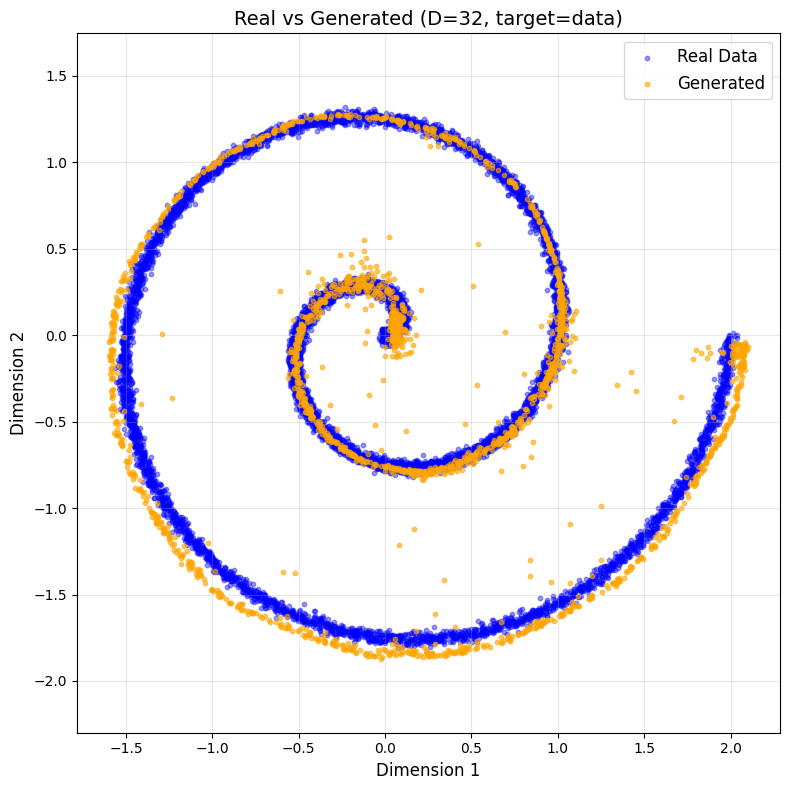


sampling - optimized Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: data
  Generating 2000 samples
tensor([0.1582, 0.1729, 0.0607, 0.1795, 0.0928, 0.2038, 0.1051, 0.0204, 0.0862,
        0.1652, 0.0064, 0.0100, 0.0016, 0.1213, 0.1530, 0.1305, 0.0406, 0.0778,
        0.2043, 0.0140, 0.0559, 0.0560, 0.1531, 0.1789, 0.0655, 0.0558, 0.1567,
        0.2183, 0.0729, 0.0448, 0.0621, 0.0757])
tensor([0.0573, 0.0426, 0.1278, 0.0429, 0.1054, 0.0231, 0.0951, 0.1599, 0.1133,
        0.0468, 0.1696, 0.1678, 0.1728, 0.0828, 0.0577, 0.0804, 0.1454, 0.1167,
        0.0246, 0.1644, 0.1337, 0.1315, 0.0631, 0.0401, 0.1245, 0.1343, 0.0566,
        0.0179, 0.1165, 0.1386, 0.1293, 0.1175])
tensor([0.0908, 0.0898, 0.1073, 0.0849, 0.1013, 0.0847, 0.0992, 0.1122, 0.1009,
        0.0948, 0.1149, 0.1140, 0.1162, 0.0968, 0.0933, 0.0937, 0.1087, 0.1015,
        0.0838, 0.1135, 0.1056, 0.1070, 0.0903, 0.0877, 0.1080, 0.1057, 0.0934,
        0.0765, 0.1054, 0.1102, 0.1051, 0.1027])
ten

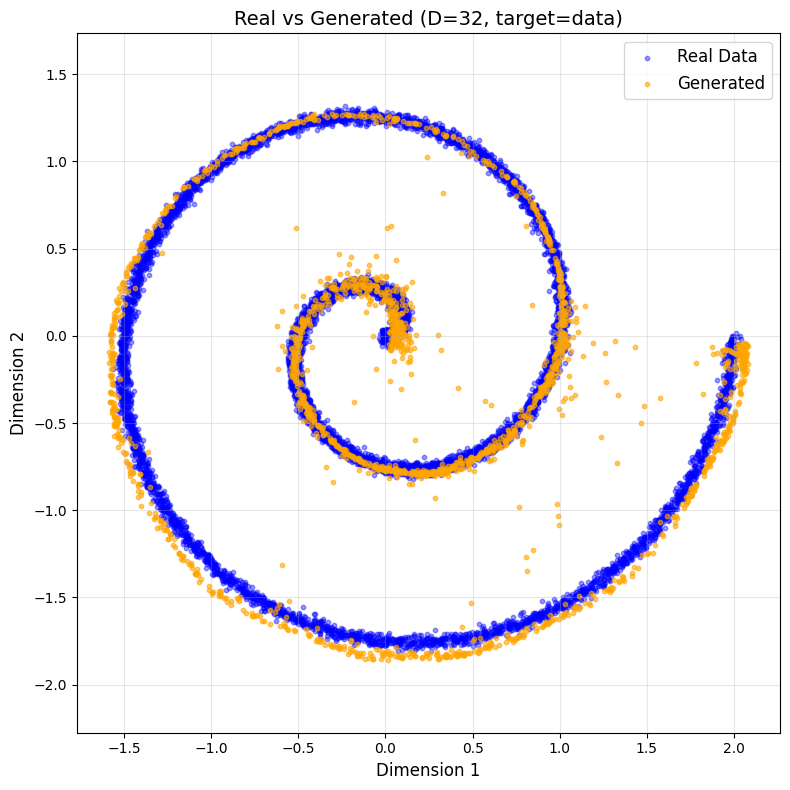

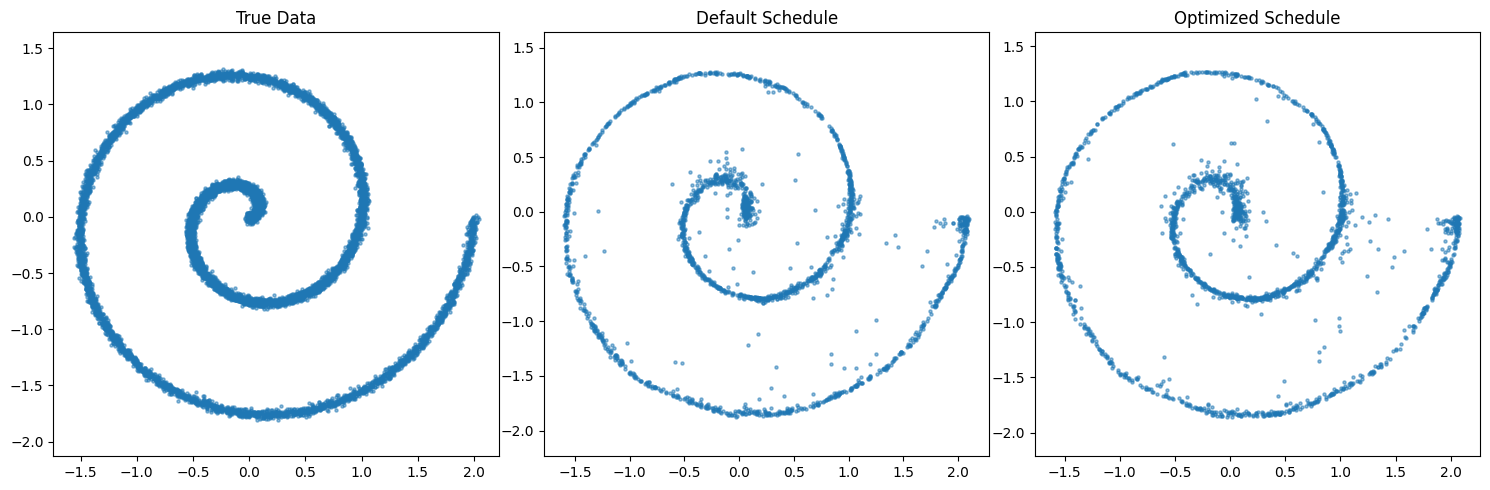

In [60]:
compare_schedules(model_data, P, t_uniform = t_default, t_optimized = t_optimized, x_true = x_hat, sigma = sigma,
                     n_points=2000, target_type="data", steps=10)

In [21]:
t_optimized

tensor([[0.0000, 0.0230, 0.1777, 0.2917, 0.4032, 0.5046, 0.6069, 0.7128, 0.7989,
         0.9115, 1.0000],
        [0.0000, 0.0173, 0.1777, 0.2921, 0.4039, 0.5053, 0.6079, 0.7148, 0.7998,
         0.9078, 1.0000],
        [0.0000, 0.0149, 0.1767, 0.2916, 0.4035, 0.5049, 0.6076, 0.7148, 0.8009,
         0.9055, 1.0000],
        [0.0000, 0.1428, 0.2122, 0.3043, 0.3990, 0.4985, 0.5973, 0.6954, 0.8242,
         0.8978, 1.0000],
        [0.0000, 0.1179, 0.2043, 0.3021, 0.4020, 0.5016, 0.6018, 0.7015, 0.7694,
         0.8972, 1.0000],
        [0.0000, 0.1041, 0.1962, 0.2979, 0.3993, 0.5006, 0.6020, 0.7047, 0.7843,
         0.9082, 1.0000],
        [0.0000, 0.0095, 0.1742, 0.2902, 0.4031, 0.5051, 0.6085, 0.7172, 0.8155,
         0.9167, 1.0000],
        [0.0000, 0.0453, 0.1823, 0.2929, 0.4027, 0.5040, 0.6062, 0.7112, 0.7941,
         0.9124, 1.0000],
        [0.0000, 0.1118, 0.1991, 0.2996, 0.4009, 0.5018, 0.6008, 0.6987, 0.7635,
         0.8931, 1.0000],
        [0.0000, 0.1478, 0.2089, 0.30

## 3.2 Observe the visualization when targeting v

In [61]:
model_v, P, x_hat, x, sigma = train_toy(
    D=32, d=2, target_type="v",
    n_samples=10000, batch_size=1024,
    epochs=500, lr=1e-3
)

x_1 = x / sigma

Data std: 0.2042
Using sigma: 0.0681
Data shape: torch.Size([10000, 32])


Training D=32, target=v:   0%|          | 2/500 [00:00<01:27,  5.70it/s]

[D=32] Epoch 1/500 | v-prediction loss: 7.4581


Training D=32, target=v:  10%|█         | 51/500 [00:09<01:12,  6.20it/s]

[D=32] Epoch 50/500 | v-prediction loss: 1.1915


Training D=32, target=v:  20%|██        | 101/500 [00:17<01:00,  6.61it/s]

[D=32] Epoch 100/500 | v-prediction loss: 0.9540


Training D=32, target=v:  30%|███       | 151/500 [00:24<00:49,  7.03it/s]

[D=32] Epoch 150/500 | v-prediction loss: 0.7820


Training D=32, target=v:  40%|████      | 201/500 [00:32<00:51,  5.81it/s]

[D=32] Epoch 200/500 | v-prediction loss: 0.6992


Training D=32, target=v:  50%|█████     | 251/500 [00:41<00:39,  6.25it/s]

[D=32] Epoch 250/500 | v-prediction loss: 0.6613


Training D=32, target=v:  60%|██████    | 300/500 [00:49<00:42,  4.66it/s]

[D=32] Epoch 300/500 | v-prediction loss: 0.5819


Training D=32, target=v:  70%|███████   | 351/500 [00:58<00:25,  5.86it/s]

[D=32] Epoch 350/500 | v-prediction loss: 0.5249


Training D=32, target=v:  80%|████████  | 401/500 [01:07<00:15,  6.29it/s]

[D=32] Epoch 400/500 | v-prediction loss: 0.4910


Training D=32, target=v:  90%|█████████ | 451/500 [01:15<00:07,  6.43it/s]

[D=32] Epoch 450/500 | v-prediction loss: 0.4723


Training D=32, target=v: 100%|██████████| 500/500 [01:23<00:00,  5.99it/s]

[D=32] Epoch 500/500 | v-prediction loss: 0.4530


In [65]:
t_default = torch.tensor([[i/M for i in range(M+1)]]*D)
t_default

tensor([[0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.30

In [66]:
t_optimized, history = learning(
    x_1=x_1,
    M = 10,
    model=model_v,
    epoch=50,
    learning_rate=0.001,
    fixed_x0=True,
    subsample=5000,
    loss_freq=1,
    eps = 0.05,
    target_type = "v",
)

print("\n=== Checking Constraints ===")
D, M_plus_1 = t_optimized.shape
M = M_plus_1 - 1
for i in [0, M//2, M]:
    sum_i = t_optimized[:, i].sum().item()
    target = i * D / M
    print(f"Step {i}: sum={sum_i:.6f}, target={target:.6f}")


Using 5000/10000 samples for optimization
Target type: v
  Model predicts: velocity v
  Weight formula: t / (1-t)
Schedule shape: torch.Size([32, 11]) (D=32, M=10)
Safe ratio: 1.0 (optimizing only first 10/10 steps)
Loss frequency: every 1 epochs
Initial loss: 60.022243



Optimizing:   2%|▏         | 1/50 [00:00<00:23,  2.13it/s]

Epoch 1/50 (odd) | Loss: 59.695396


Optimizing:   4%|▍         | 2/50 [00:00<00:20,  2.32it/s]

Epoch 2/50 (even) | Loss: 59.673943


Optimizing:   6%|▌         | 3/50 [00:01<00:22,  2.13it/s]

Epoch 3/50 (odd) | Loss: 59.388039


Optimizing:   8%|▊         | 4/50 [00:01<00:19,  2.36it/s]

Epoch 4/50 (even) | Loss: 59.365036


Optimizing:  10%|█         | 5/50 [00:02<00:17,  2.52it/s]

Epoch 5/50 (odd) | Loss: 59.097778


Optimizing:  12%|█▏        | 6/50 [00:02<00:16,  2.69it/s]

Epoch 6/50 (even) | Loss: 59.074875


Optimizing:  14%|█▍        | 7/50 [00:02<00:15,  2.70it/s]

Epoch 7/50 (odd) | Loss: 58.816673


Optimizing:  16%|█▌        | 8/50 [00:03<00:15,  2.80it/s]

Epoch 8/50 (even) | Loss: 58.793888


Optimizing:  18%|█▊        | 9/50 [00:03<00:16,  2.49it/s]

Epoch 9/50 (odd) | Loss: 58.540401


Optimizing:  20%|██        | 10/50 [00:03<00:14,  2.70it/s]

Epoch 10/50 (even) | Loss: 58.517387


Optimizing:  22%|██▏       | 11/50 [00:04<00:16,  2.43it/s]

Epoch 11/50 (odd) | Loss: 58.270615


Optimizing:  24%|██▍       | 12/50 [00:04<00:14,  2.57it/s]

Epoch 12/50 (even) | Loss: 58.247814


Optimizing:  26%|██▌       | 13/50 [00:05<00:14,  2.64it/s]

Epoch 13/50 (odd) | Loss: 58.004978


Optimizing:  28%|██▊       | 14/50 [00:05<00:13,  2.67it/s]

Epoch 14/50 (even) | Loss: 57.982178


Optimizing:  30%|███       | 15/50 [00:05<00:13,  2.61it/s]

Epoch 15/50 (odd) | Loss: 57.741287


Optimizing:  32%|███▏      | 16/50 [00:06<00:12,  2.75it/s]

Epoch 16/50 (even) | Loss: 57.718521


Optimizing:  34%|███▍      | 17/50 [00:06<00:12,  2.68it/s]

Epoch 17/50 (odd) | Loss: 57.480026


Optimizing:  36%|███▌      | 18/50 [00:06<00:11,  2.89it/s]

Epoch 18/50 (even) | Loss: 57.457253


Optimizing:  38%|███▊      | 19/50 [00:07<00:10,  2.92it/s]

Epoch 19/50 (odd) | Loss: 57.219788


Optimizing:  40%|████      | 20/50 [00:07<00:10,  2.87it/s]

Epoch 20/50 (even) | Loss: 57.197044


Optimizing:  42%|████▏     | 21/50 [00:07<00:09,  2.91it/s]

Epoch 21/50 (odd) | Loss: 56.961159


Optimizing:  44%|████▍     | 22/50 [00:08<00:08,  3.12it/s]

Epoch 22/50 (even) | Loss: 56.938446


Optimizing:  46%|████▌     | 23/50 [00:08<00:09,  2.99it/s]

Epoch 23/50 (odd) | Loss: 56.703907


Optimizing:  48%|████▊     | 24/50 [00:08<00:08,  3.16it/s]

Epoch 24/50 (even) | Loss: 56.681297


Optimizing:  50%|█████     | 25/50 [00:09<00:08,  2.95it/s]

Epoch 25/50 (odd) | Loss: 56.448395


Optimizing:  52%|█████▏    | 26/50 [00:09<00:09,  2.54it/s]

Epoch 26/50 (even) | Loss: 56.425762


Optimizing:  54%|█████▍    | 27/50 [00:10<00:09,  2.54it/s]

Epoch 27/50 (odd) | Loss: 56.194168


Optimizing:  56%|█████▌    | 28/50 [00:10<00:08,  2.45it/s]

Epoch 28/50 (even) | Loss: 56.171547


Optimizing:  58%|█████▊    | 29/50 [00:10<00:08,  2.57it/s]

Epoch 29/50 (odd) | Loss: 55.941864


Optimizing:  60%|██████    | 30/50 [00:11<00:07,  2.72it/s]

Epoch 30/50 (even) | Loss: 55.919254


Optimizing:  62%|██████▏   | 31/50 [00:13<00:15,  1.20it/s]

Epoch 31/50 (odd) | Loss: 55.693398


Optimizing:  64%|██████▍   | 32/50 [00:13<00:14,  1.26it/s]

Epoch 32/50 (even) | Loss: 55.670586


Optimizing:  66%|██████▌   | 33/50 [00:14<00:11,  1.46it/s]

Epoch 33/50 (odd) | Loss: 55.503555


Optimizing:  68%|██████▊   | 34/50 [00:14<00:09,  1.73it/s]

Epoch 34/50 (even) | Loss: 55.480640


Optimizing:  70%|███████   | 35/50 [00:15<00:08,  1.87it/s]

Epoch 35/50 (odd) | Loss: 55.316452


Optimizing:  72%|███████▏  | 36/50 [00:15<00:06,  2.11it/s]

Epoch 36/50 (even) | Loss: 55.293465


Optimizing:  74%|███████▍  | 37/50 [00:15<00:05,  2.29it/s]

Epoch 37/50 (odd) | Loss: 55.125015


Optimizing:  76%|███████▌  | 38/50 [00:16<00:05,  2.33it/s]

Epoch 38/50 (even) | Loss: 55.101784


Optimizing:  78%|███████▊  | 39/50 [00:16<00:05,  2.03it/s]

Epoch 39/50 (odd) | Loss: 54.934078


Optimizing:  80%|████████  | 40/50 [00:17<00:04,  2.13it/s]

Epoch 40/50 (even) | Loss: 54.910698


Optimizing:  82%|████████▏ | 41/50 [00:17<00:04,  2.06it/s]

Epoch 41/50 (odd) | Loss: 54.745346


Optimizing:  84%|████████▍ | 42/50 [00:18<00:03,  2.19it/s]

Epoch 42/50 (even) | Loss: 54.722038


Optimizing:  86%|████████▌ | 43/50 [00:18<00:03,  2.26it/s]

Epoch 43/50 (odd) | Loss: 54.558434


Optimizing:  88%|████████▊ | 44/50 [00:18<00:02,  2.44it/s]

Epoch 44/50 (even) | Loss: 54.534920


Optimizing:  90%|█████████ | 45/50 [00:19<00:02,  2.48it/s]

Epoch 45/50 (odd) | Loss: 54.372742


Optimizing:  92%|█████████▏| 46/50 [00:19<00:01,  2.76it/s]

Epoch 46/50 (even) | Loss: 54.349068


Optimizing:  94%|█████████▍| 47/50 [00:21<00:02,  1.38it/s]

Epoch 47/50 (odd) | Loss: 54.189445


Optimizing:  96%|█████████▌| 48/50 [00:22<00:02,  1.06s/it]

Epoch 48/50 (even) | Loss: 54.165604


Optimizing:  98%|█████████▊| 49/50 [00:23<00:01,  1.03s/it]

Epoch 49/50 (odd) | Loss: 54.042526


Optimizing: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]

Epoch 50/50 (even) | Loss: 54.018547



Final loss (full 10000 samples): 54.441483
Final loss (subsample): 54.018547
Sum constraints: [0.0, 16.0, 32.0]

=== Checking Constraints ===
Step 0: sum=0.000000, target=0.000000
Step 5: sum=16.000000, target=16.000000
Step 10: sum=32.000000, target=32.000000


sampling - uniform Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: v
  Generating 2000 samples
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000])
tensor([0

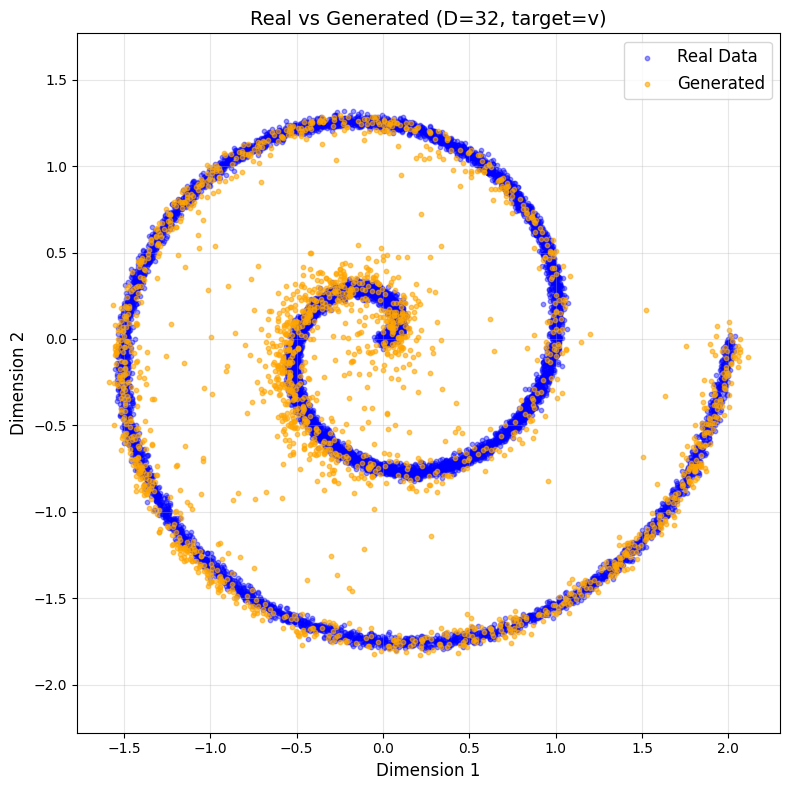


sampling - optimized Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: v
  Generating 2000 samples
tensor([0.1466, 0.0866, 0.0667, 0.0994, 0.0534, 0.1058, 0.0763, 0.0120, 0.2632,
        0.0363, 0.0506, 0.0458, 0.1202, 0.0441, 0.0414, 0.0199, 0.1724, 0.0606,
        0.0963, 0.1007, 0.0776, 0.1797, 0.1469, 0.0965, 0.0594, 0.1078, 0.1131,
        0.2303, 0.1053, 0.0706, 0.0613, 0.2435])
tensor([0.0701, 0.1126, 0.1224, 0.0912, 0.1308, 0.1030, 0.1242, 0.1611, 0.0029,
        0.1377, 0.1346, 0.1393, 0.0898, 0.1351, 0.1369, 0.1534, 0.0488, 0.1298,
        0.1030, 0.0992, 0.1150, 0.0426, 0.0731, 0.1051, 0.1200, 0.0970, 0.0887,
        0.0014, 0.0905, 0.1159, 0.1323, 0.0022])
tensor([0.0882, 0.1016, 0.1057, 0.1066, 0.1098, 0.0970, 0.1003, 0.1169, 0.0560,
        0.1156, 0.1090, 0.1098, 0.0937, 0.1134, 0.1133, 0.1160, 0.0868, 0.1083,
        0.0973, 0.1003, 0.1043, 0.0851, 0.0886, 0.0999, 0.1113, 0.0981, 0.1009,
        0.0789, 0.1030, 0.1079, 0.1036, 0.0727])
tensor

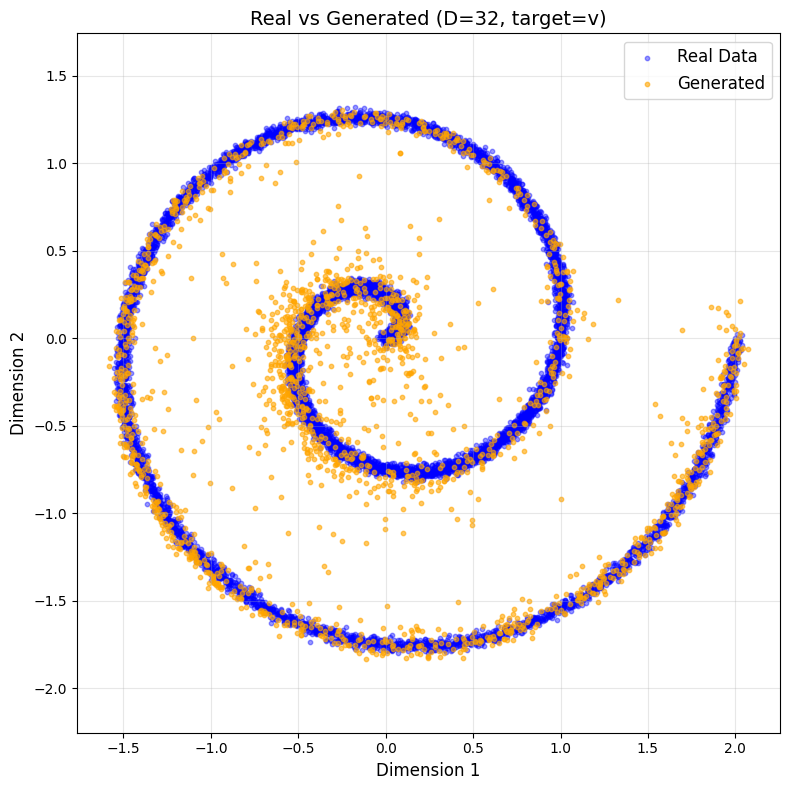

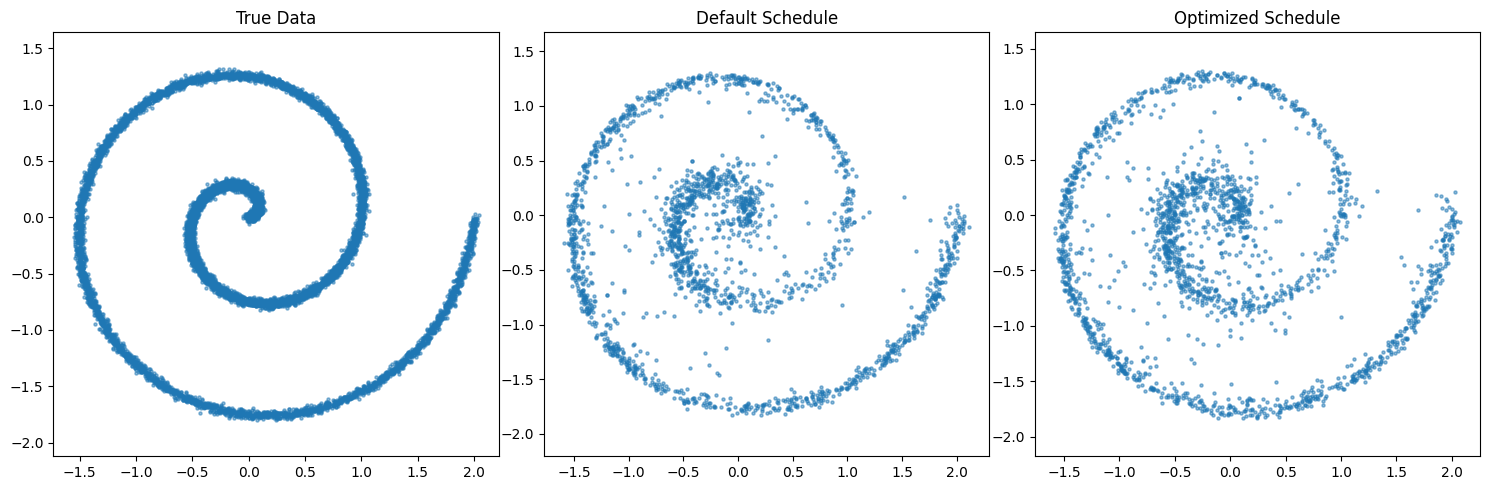

In [67]:
compare_schedules(model_v, P, t_uniform = t_default, t_optimized = t_optimized, x_true = x_hat, sigma = sigma,
                     n_points=2000, target_type="v", steps = 10)

# 4. Try for different noise schedules?

First, we try some extreme initials

In [68]:
t_extreme = torch.tensor([[i/(5*M) for i in range((M+1)//2)]+[1-i/(4*M) for i in range((M+1)//2,-1,-1)]]*D)
t_extreme

tensor([[0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.8750, 0.9000, 0.9250, 0.9500,
         0.9750, 1.0000],
        [0.0000, 0.0200, 0.0400, 0.06

In [70]:
t_optimized, history = learning(
    x_1=x_1,
    M = 10,
    model=model_v,
    epoch=50,
    learning_rate=0.001,
    fixed_x0=True,
    subsample=5000,
    loss_freq=1,
    eps = 0.05,
    target_type = "v",
    t_initial = t_extreme
)

print("\n=== Checking Constraints ===")
D, M_plus_1 = t_optimized.shape
M = M_plus_1 - 1
for i in [0, M//2, M]:
    sum_i = t_optimized[:, i].sum().item()
    target = i * D / M
    print(f"Step {i}: sum={sum_i:.6f}, target={target:.6f}")


Using 5000/10000 samples for optimization
Target type: v
  Model predicts: velocity v
  Weight formula: t / (1-t)
Schedule shape: torch.Size([32, 11]) (D=32, M=10)
Safe ratio: 1.0 (optimizing only first 10/10 steps)
Loss frequency: every 1 epochs
Initial loss: 305.447845



Optimizing:   2%|▏         | 1/50 [00:00<00:24,  1.96it/s]

Epoch 1/50 (odd) | Loss: 240.092056


Optimizing:   4%|▍         | 2/50 [00:00<00:20,  2.39it/s]

Epoch 2/50 (even) | Loss: 181.407303


Optimizing:   6%|▌         | 3/50 [00:01<00:27,  1.73it/s]

Epoch 3/50 (odd) | Loss: 98.694580


Optimizing:   8%|▊         | 4/50 [00:02<00:29,  1.55it/s]

Epoch 4/50 (even) | Loss: 66.061218


Optimizing:  10%|█         | 5/50 [00:02<00:26,  1.72it/s]

Epoch 5/50 (odd) | Loss: 60.812946


Optimizing:  12%|█▏        | 6/50 [00:03<00:23,  1.85it/s]

Epoch 6/50 (even) | Loss: 60.791317


Optimizing:  14%|█▍        | 7/50 [00:03<00:22,  1.94it/s]

Epoch 7/50 (odd) | Loss: 60.466270


Optimizing:  16%|█▌        | 8/50 [00:04<00:20,  2.01it/s]

Epoch 8/50 (even) | Loss: 60.443542


Optimizing:  18%|█▊        | 9/50 [00:04<00:22,  1.81it/s]

Epoch 9/50 (odd) | Loss: 60.137260


Optimizing:  20%|██        | 10/50 [00:05<00:22,  1.79it/s]

Epoch 10/50 (even) | Loss: 60.114025


Optimizing:  22%|██▏       | 11/50 [00:06<00:23,  1.66it/s]

Epoch 11/50 (odd) | Loss: 59.816063


Optimizing:  24%|██▍       | 12/50 [00:06<00:22,  1.70it/s]

Epoch 12/50 (even) | Loss: 59.792591


Optimizing:  26%|██▌       | 13/50 [00:08<00:40,  1.09s/it]

Epoch 13/50 (odd) | Loss: 59.501511


Optimizing:  28%|██▊       | 14/50 [00:09<00:32,  1.12it/s]

Epoch 14/50 (even) | Loss: 59.477970


Optimizing:  30%|███       | 15/50 [00:10<00:33,  1.04it/s]

Epoch 15/50 (odd) | Loss: 59.194080


Optimizing:  32%|███▏      | 16/50 [00:13<00:53,  1.56s/it]

Epoch 16/50 (even) | Loss: 59.170532


Optimizing:  34%|███▍      | 17/50 [00:14<00:43,  1.32s/it]

Epoch 17/50 (odd) | Loss: 58.891762


Optimizing:  36%|███▌      | 18/50 [00:14<00:34,  1.07s/it]

Epoch 18/50 (even) | Loss: 58.868225


Optimizing:  38%|███▊      | 19/50 [00:15<00:30,  1.01it/s]

Epoch 19/50 (odd) | Loss: 58.592030


Optimizing:  40%|████      | 20/50 [00:16<00:28,  1.04it/s]

Epoch 20/50 (even) | Loss: 58.568382


Optimizing:  42%|████▏     | 21/50 [00:17<00:25,  1.14it/s]

Epoch 21/50 (odd) | Loss: 58.296185


Optimizing:  44%|████▍     | 22/50 [00:17<00:22,  1.23it/s]

Epoch 22/50 (even) | Loss: 58.272514


Optimizing:  46%|████▌     | 23/50 [00:18<00:20,  1.31it/s]

Epoch 23/50 (odd) | Loss: 58.004360


Optimizing:  48%|████▊     | 24/50 [00:19<00:18,  1.42it/s]

Epoch 24/50 (even) | Loss: 57.980644


Optimizing:  50%|█████     | 25/50 [00:19<00:18,  1.33it/s]

Epoch 25/50 (odd) | Loss: 57.717758


Optimizing:  52%|█████▏    | 26/50 [00:20<00:17,  1.34it/s]

Epoch 26/50 (even) | Loss: 57.693954


Optimizing:  54%|█████▍    | 27/50 [00:21<00:15,  1.47it/s]

Epoch 27/50 (odd) | Loss: 57.434898


Optimizing:  56%|█████▌    | 28/50 [00:21<00:13,  1.57it/s]

Epoch 28/50 (even) | Loss: 57.410934


Optimizing:  58%|█████▊    | 29/50 [00:22<00:13,  1.54it/s]

Epoch 29/50 (odd) | Loss: 57.154892


Optimizing:  60%|██████    | 30/50 [00:22<00:12,  1.64it/s]

Epoch 30/50 (even) | Loss: 57.130802


Optimizing:  62%|██████▏   | 31/50 [00:23<00:10,  1.78it/s]

Epoch 31/50 (odd) | Loss: 56.878227


Optimizing:  64%|██████▍   | 32/50 [00:23<00:10,  1.70it/s]

Epoch 32/50 (even) | Loss: 56.854057


Optimizing:  66%|██████▌   | 33/50 [00:24<00:10,  1.62it/s]

Epoch 33/50 (odd) | Loss: 56.605141


Optimizing:  68%|██████▊   | 34/50 [00:25<00:09,  1.71it/s]

Epoch 34/50 (even) | Loss: 56.580864


Optimizing:  70%|███████   | 35/50 [00:25<00:08,  1.67it/s]

Epoch 35/50 (odd) | Loss: 56.397293


Optimizing:  72%|███████▏  | 36/50 [00:26<00:08,  1.67it/s]

Epoch 36/50 (even) | Loss: 56.372932


Optimizing:  74%|███████▍  | 37/50 [00:27<00:08,  1.48it/s]

Epoch 37/50 (odd) | Loss: 56.199341


Optimizing:  76%|███████▌  | 38/50 [00:27<00:07,  1.51it/s]

Epoch 38/50 (even) | Loss: 56.174896


Optimizing:  78%|███████▊  | 39/50 [00:28<00:07,  1.50it/s]

Epoch 39/50 (odd) | Loss: 55.997566


Optimizing:  80%|████████  | 40/50 [00:29<00:07,  1.38it/s]

Epoch 40/50 (even) | Loss: 55.972992


Optimizing:  82%|████████▏ | 41/50 [00:30<00:06,  1.34it/s]

Epoch 41/50 (odd) | Loss: 55.797890


Optimizing:  84%|████████▍ | 42/50 [00:30<00:05,  1.43it/s]

Epoch 42/50 (even) | Loss: 55.773193


Optimizing:  86%|████████▌ | 43/50 [00:31<00:04,  1.42it/s]

Epoch 43/50 (odd) | Loss: 55.601162


Optimizing:  88%|████████▊ | 44/50 [00:32<00:04,  1.38it/s]

Epoch 44/50 (even) | Loss: 55.576389


Optimizing:  90%|█████████ | 45/50 [00:32<00:03,  1.61it/s]

Epoch 45/50 (odd) | Loss: 55.407043


Optimizing:  92%|█████████▏| 46/50 [00:33<00:02,  1.74it/s]

Epoch 46/50 (even) | Loss: 55.382092


Optimizing:  94%|█████████▍| 47/50 [00:33<00:01,  1.78it/s]

Epoch 47/50 (odd) | Loss: 55.214733


Optimizing:  96%|█████████▌| 48/50 [00:35<00:01,  1.24it/s]

Epoch 48/50 (even) | Loss: 55.189671


Optimizing:  98%|█████████▊| 49/50 [00:35<00:00,  1.28it/s]

Epoch 49/50 (odd) | Loss: 55.053230


Optimizing: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]

Epoch 50/50 (even) | Loss: 55.028099



Final loss (full 10000 samples): 54.455059
Final loss (subsample): 55.028099
Sum constraints: [0.0, 15.999999046325684, 32.0]

=== Checking Constraints ===
Step 0: sum=0.000000, target=0.000000
Step 5: sum=15.999999, target=16.000000
Step 10: sum=32.000000, target=32.000000


In [71]:
t_optimized

tensor([[0.0000, 0.1435, 0.2156, 0.3066, 0.4041, 0.5011, 0.5933, 0.6924, 0.7928,
         0.8960, 1.0000],
        [0.0000, 0.0881, 0.1974, 0.2990, 0.3994, 0.4995, 0.5986, 0.6983, 0.7974,
         0.8970, 1.0000],
        [0.0000, 0.0644, 0.1849, 0.2920, 0.3944, 0.5003, 0.6079, 0.7081, 0.8081,
         0.9054, 1.0000],
        [0.0000, 0.0956, 0.1904, 0.2973, 0.3988, 0.4990, 0.6025, 0.7027, 0.8027,
         0.9019, 1.0000],
        [0.0000, 0.0524, 0.1829, 0.2917, 0.3957, 0.4970, 0.6003, 0.7001, 0.7995,
         0.8994, 1.0000],
        [0.0000, 0.1066, 0.2113, 0.3083, 0.4055, 0.5035, 0.5959, 0.6949, 0.7951,
         0.8978, 1.0000],
        [0.0000, 0.0807, 0.1996, 0.3012, 0.4000, 0.4998, 0.6041, 0.7049, 0.8050,
         0.9027, 1.0000],
        [0.0000, 0.0123, 0.1672, 0.2829, 0.3895, 0.5073, 0.6180, 0.7214, 0.8199,
         0.9097, 1.0000],
        [0.0000, 0.2726, 0.2756, 0.3342, 0.4219, 0.5019, 0.5790, 0.6775, 0.7800,
         0.8900, 1.0000],
        [0.0000, 0.0366, 0.1704, 0.28

sampling - uniform Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: v
  Generating 2000 samples
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200])
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200])
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200])
tensor([0

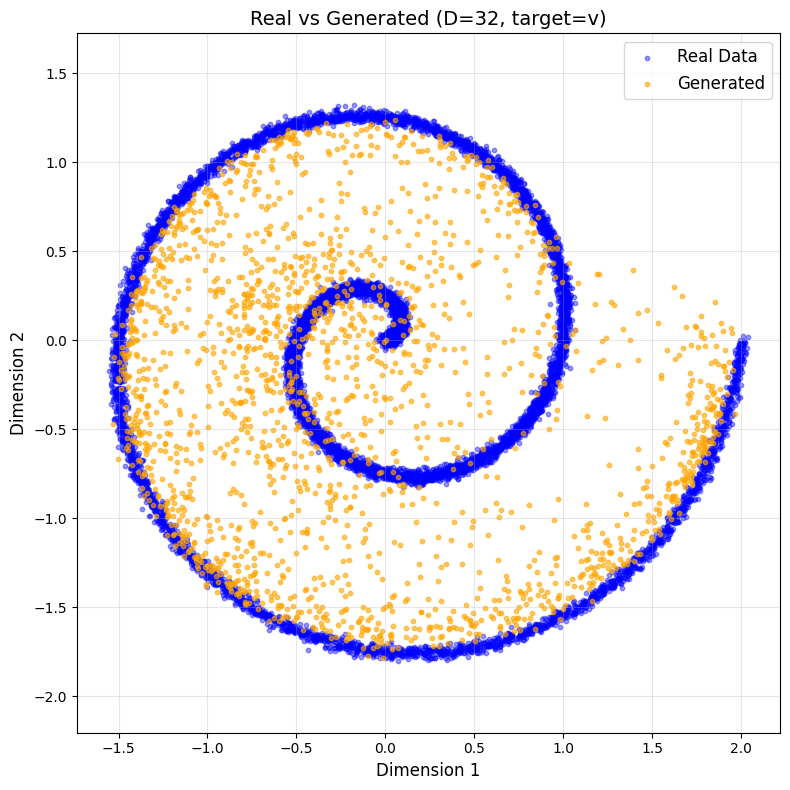


sampling - optimized Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: v
  Generating 2000 samples
tensor([0.1435, 0.0881, 0.0644, 0.0956, 0.0524, 0.1066, 0.0807, 0.0123, 0.2726,
        0.0366, 0.0514, 0.0446, 0.1198, 0.0447, 0.0413, 0.0210, 0.1670, 0.0618,
        0.0981, 0.0945, 0.0744, 0.1756, 0.1452, 0.1009, 0.0645, 0.1085, 0.1241,
        0.2258, 0.1020, 0.0728, 0.0632, 0.2402])
tensor([0.0721, 0.1092, 0.1205, 0.0948, 0.1305, 0.1047, 0.1189, 0.1549, 0.0030,
        0.1338, 0.1305, 0.1353, 0.0884, 0.1326, 0.1345, 0.1482, 0.0578, 0.1255,
        0.1021, 0.1067, 0.1154, 0.0525, 0.0756, 0.1022, 0.1153, 0.0949, 0.0873,
        0.0122, 0.0936, 0.1118, 0.1283, 0.0126])
tensor([0.0909, 0.1016, 0.1071, 0.1069, 0.1088, 0.0970, 0.1016, 0.1157, 0.0586,
        0.1150, 0.1092, 0.1103, 0.0968, 0.1121, 0.1113, 0.1146, 0.0878, 0.1091,
        0.0977, 0.0987, 0.1050, 0.0835, 0.0901, 0.0985, 0.1097, 0.0999, 0.0956,
        0.0796, 0.1028, 0.1086, 0.1036, 0.0724])
tensor

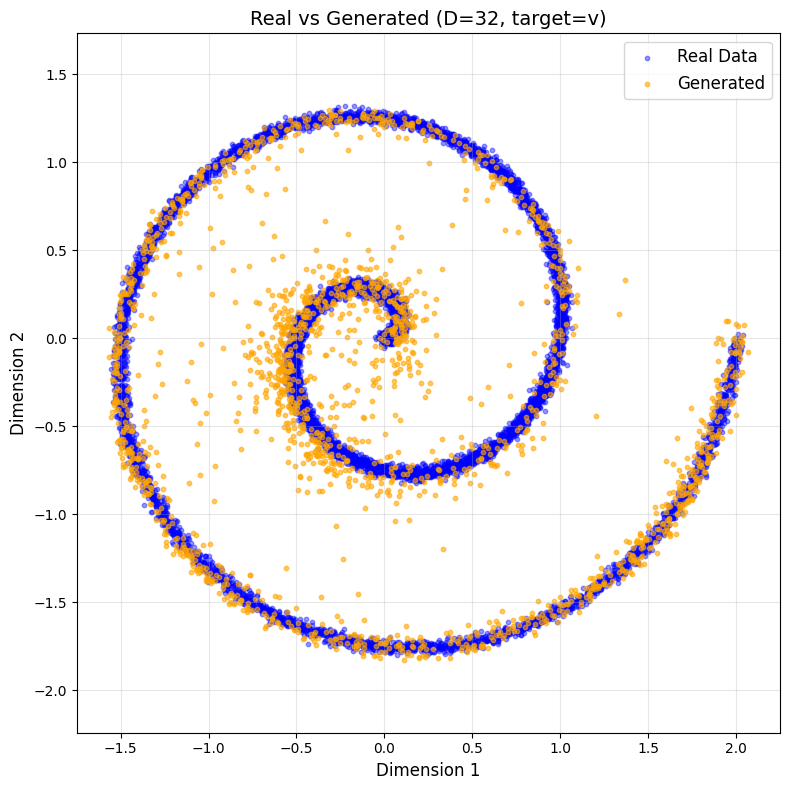

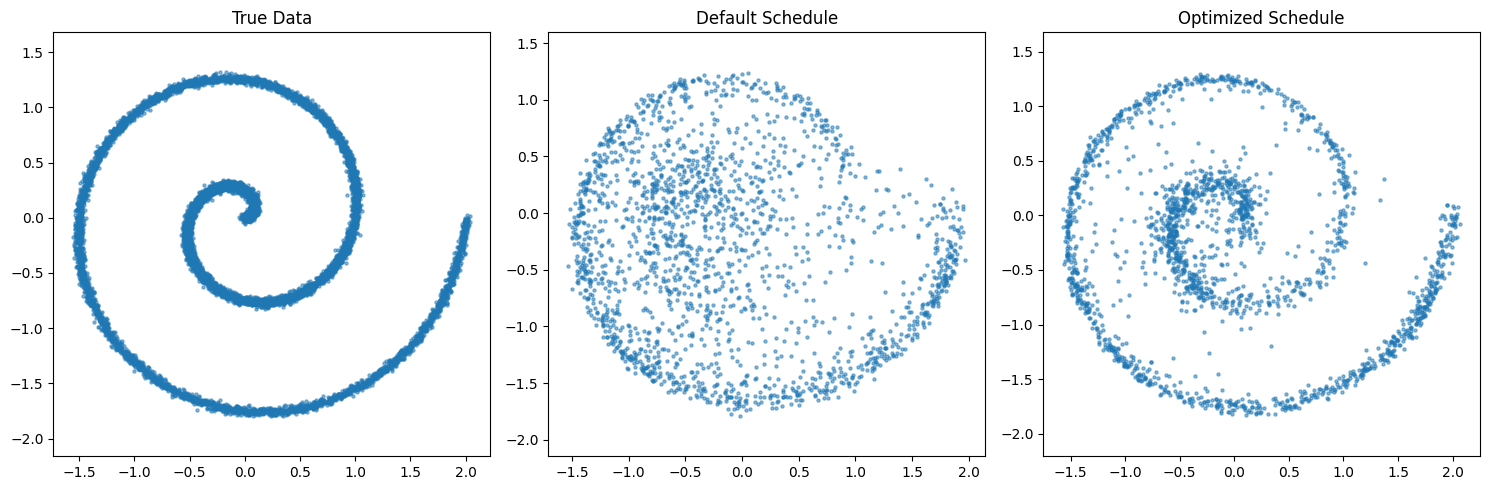

In [72]:
compare_schedules(model_v, P, t_uniform = t_extreme, t_optimized = t_optimized, x_true = x_hat, sigma = sigma,
                     n_points=2000, target_type="v", steps = 10)

Now we try random schedule

In [73]:
mid = torch.rand((D, M-1))

zeros = torch.zeros((D, 1))
ones  = torch.ones((D, 1))
t_random = torch.cat([zeros, mid, ones], dim=1)

t_random, _ = torch.sort(t_random, dim=1)
t_random

tensor([[0.0000, 0.0485, 0.1456, 0.2545, 0.3841, 0.3884, 0.4319, 0.4353, 0.4556,
         0.5923, 1.0000],
        [0.0000, 0.0083, 0.2867, 0.3829, 0.6607, 0.7693, 0.8117, 0.9086, 0.9395,
         0.9524, 1.0000],
        [0.0000, 0.0143, 0.1097, 0.2147, 0.2879, 0.3037, 0.3256, 0.4379, 0.9310,
         0.9540, 1.0000],
        [0.0000, 0.0725, 0.2202, 0.2660, 0.2805, 0.3334, 0.6062, 0.7109, 0.7182,
         0.8012, 1.0000],
        [0.0000, 0.0042, 0.0386, 0.0674, 0.1151, 0.3059, 0.4391, 0.6973, 0.8522,
         0.8861, 1.0000],
        [0.0000, 0.1674, 0.3021, 0.3651, 0.3973, 0.5365, 0.5992, 0.6201, 0.7058,
         0.9389, 1.0000],
        [0.0000, 0.0579, 0.2527, 0.4090, 0.6648, 0.7791, 0.8217, 0.8772, 0.9221,
         0.9915, 1.0000],
        [0.0000, 0.0491, 0.1225, 0.3282, 0.3310, 0.6227, 0.6467, 0.6832, 0.8740,
         0.9530, 1.0000],
        [0.0000, 0.0369, 0.0653, 0.0901, 0.2776, 0.3446, 0.4158, 0.4655, 0.6651,
         0.9460, 1.0000],
        [0.0000, 0.0757, 0.0962, 0.11

In [74]:
t_optimized, history = learning(
    x_1=x_1,
    M = 10,
    model=model_v,
    epoch=50,
    learning_rate=0.001,
    fixed_x0=True,
    subsample=5000,
    loss_freq=1,
    eps = 0.05,
    target_type = "v",
    t_initial = t_random
)

print("\n=== Checking Constraints ===")
D, M_plus_1 = t_optimized.shape
M = M_plus_1 - 1
for i in [0, M//2, M]:
    sum_i = t_optimized[:, i].sum().item()
    target = i * D / M
    print(f"Step {i}: sum={sum_i:.6f}, target={target:.6f}")


Using 5000/10000 samples for optimization
Target type: v
  Model predicts: velocity v
  Weight formula: t / (1-t)
Schedule shape: torch.Size([32, 11]) (D=32, M=10)
Safe ratio: 1.0 (optimizing only first 10/10 steps)
Loss frequency: every 1 epochs
Initial loss: 106.190041



Optimizing:   2%|▏         | 1/50 [00:01<01:31,  1.88s/it]

Epoch 1/50 (odd) | Loss: 92.696167


Optimizing:   4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

Epoch 2/50 (even) | Loss: 86.466904


Optimizing:   6%|▌         | 3/50 [00:03<00:57,  1.23s/it]

Epoch 3/50 (odd) | Loss: 81.097076


Optimizing:   8%|▊         | 4/50 [00:04<00:43,  1.06it/s]

Epoch 4/50 (even) | Loss: 79.748344


Optimizing:  10%|█         | 5/50 [00:04<00:34,  1.31it/s]

Epoch 5/50 (odd) | Loss: 74.243027


Optimizing:  12%|█▏        | 6/50 [00:05<00:28,  1.56it/s]

Epoch 6/50 (even) | Loss: 73.705978


Optimizing:  14%|█▍        | 7/50 [00:07<00:48,  1.12s/it]

Epoch 7/50 (odd) | Loss: 71.326157


Optimizing:  16%|█▌        | 8/50 [00:07<00:36,  1.14it/s]

Epoch 8/50 (even) | Loss: 71.226425


Optimizing:  18%|█▊        | 9/50 [00:08<00:30,  1.36it/s]

Epoch 9/50 (odd) | Loss: 67.579704


Optimizing:  20%|██        | 10/50 [00:08<00:24,  1.61it/s]

Epoch 10/50 (even) | Loss: 67.492744


Optimizing:  22%|██▏       | 11/50 [00:08<00:21,  1.82it/s]

Epoch 11/50 (odd) | Loss: 66.129608


Optimizing:  24%|██▍       | 12/50 [00:09<00:18,  2.03it/s]

Epoch 12/50 (even) | Loss: 66.056694


Optimizing:  26%|██▌       | 13/50 [00:11<00:34,  1.08it/s]

Epoch 13/50 (odd) | Loss: 64.881706


Optimizing:  28%|██▊       | 14/50 [00:12<00:35,  1.02it/s]

Epoch 14/50 (even) | Loss: 64.818390


Optimizing:  30%|███       | 15/50 [00:13<00:37,  1.07s/it]

Epoch 15/50 (odd) | Loss: 63.539989


Optimizing:  32%|███▏      | 16/50 [00:14<00:34,  1.01s/it]

Epoch 16/50 (even) | Loss: 63.479256


Optimizing:  34%|███▍      | 17/50 [00:15<00:33,  1.01s/it]

Epoch 17/50 (odd) | Loss: 62.359200


Optimizing:  36%|███▌      | 18/50 [00:15<00:26,  1.20it/s]

Epoch 18/50 (even) | Loss: 62.285080


Optimizing:  38%|███▊      | 19/50 [00:16<00:22,  1.38it/s]

Epoch 19/50 (odd) | Loss: 60.726067


Optimizing:  40%|████      | 20/50 [00:16<00:19,  1.57it/s]

Epoch 20/50 (even) | Loss: 60.608551


Optimizing:  42%|████▏     | 21/50 [00:17<00:17,  1.65it/s]

Epoch 21/50 (odd) | Loss: 60.089241


Optimizing:  44%|████▍     | 22/50 [00:17<00:14,  1.88it/s]

Epoch 22/50 (even) | Loss: 59.978134


Optimizing:  46%|████▌     | 23/50 [00:18<00:13,  1.96it/s]

Epoch 23/50 (odd) | Loss: 59.559204


Optimizing:  48%|████▊     | 24/50 [00:18<00:12,  2.11it/s]

Epoch 24/50 (even) | Loss: 59.455109


Optimizing:  50%|█████     | 25/50 [00:19<00:11,  2.15it/s]

Epoch 25/50 (odd) | Loss: 59.120522


Optimizing:  52%|█████▏    | 26/50 [00:19<00:10,  2.36it/s]

Epoch 26/50 (even) | Loss: 59.020058


Optimizing:  54%|█████▍    | 27/50 [00:19<00:09,  2.39it/s]

Epoch 27/50 (odd) | Loss: 58.733086


Optimizing:  56%|█████▌    | 28/50 [00:20<00:09,  2.42it/s]

Epoch 28/50 (even) | Loss: 58.637253


Optimizing:  58%|█████▊    | 29/50 [00:20<00:08,  2.35it/s]

Epoch 29/50 (odd) | Loss: 58.410503


Optimizing:  60%|██████    | 30/50 [00:21<00:12,  1.66it/s]

Epoch 30/50 (even) | Loss: 58.318619


Optimizing:  62%|██████▏   | 31/50 [00:22<00:10,  1.75it/s]

Epoch 31/50 (odd) | Loss: 58.131340


Optimizing:  64%|██████▍   | 32/50 [00:22<00:09,  1.95it/s]

Epoch 32/50 (even) | Loss: 58.043144


Optimizing:  66%|██████▌   | 33/50 [00:22<00:08,  2.06it/s]

Epoch 33/50 (odd) | Loss: 57.889626


Optimizing:  68%|██████▊   | 34/50 [00:23<00:07,  2.13it/s]

Epoch 34/50 (even) | Loss: 57.806984


Optimizing:  70%|███████   | 35/50 [00:23<00:06,  2.18it/s]

Epoch 35/50 (odd) | Loss: 57.660683


Optimizing:  72%|███████▏  | 36/50 [00:26<00:14,  1.04s/it]

Epoch 36/50 (even) | Loss: 57.583244


Optimizing:  74%|███████▍  | 37/50 [00:27<00:14,  1.08s/it]

Epoch 37/50 (odd) | Loss: 57.449306


Optimizing:  76%|███████▌  | 38/50 [00:28<00:14,  1.21s/it]

Epoch 38/50 (even) | Loss: 57.374889


Optimizing:  78%|███████▊  | 39/50 [00:29<00:12,  1.13s/it]

Epoch 39/50 (odd) | Loss: 57.246616


Optimizing:  80%|████████  | 40/50 [00:30<00:09,  1.07it/s]

Epoch 40/50 (even) | Loss: 57.175415


Optimizing:  82%|████████▏ | 41/50 [00:31<00:08,  1.03it/s]

Epoch 41/50 (odd) | Loss: 57.048615


Optimizing:  84%|████████▍ | 42/50 [00:33<00:11,  1.41s/it]

Epoch 42/50 (even) | Loss: 56.979637


Optimizing:  86%|████████▌ | 43/50 [00:34<00:09,  1.29s/it]

Epoch 43/50 (odd) | Loss: 56.867714


Optimizing:  88%|████████▊ | 44/50 [00:35<00:06,  1.09s/it]

Epoch 44/50 (even) | Loss: 56.805725


Optimizing:  90%|█████████ | 45/50 [00:36<00:04,  1.00it/s]

Epoch 45/50 (odd) | Loss: 56.713745


Optimizing:  92%|█████████▏| 46/50 [00:36<00:03,  1.22it/s]

Epoch 46/50 (even) | Loss: 56.660507


Optimizing:  94%|█████████▍| 47/50 [00:37<00:02,  1.28it/s]

Epoch 47/50 (odd) | Loss: 56.571373


Optimizing:  96%|█████████▌| 48/50 [00:37<00:01,  1.37it/s]

Epoch 48/50 (even) | Loss: 56.519897


Optimizing:  98%|█████████▊| 49/50 [00:38<00:00,  1.33it/s]

Epoch 49/50 (odd) | Loss: 56.426842


Optimizing: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]

Epoch 50/50 (even) | Loss: 56.376862



Final loss (full 10000 samples): 56.192352
Final loss (subsample): 56.376862
Sum constraints: [0.0, 16.0, 32.0]

=== Checking Constraints ===
Step 0: sum=0.000000, target=0.000000
Step 5: sum=16.000000, target=16.000000
Step 10: sum=32.000000, target=32.000000


sampling - uniform Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: v
  Generating 2000 samples
tensor([0.0485, 0.0083, 0.0143, 0.0725, 0.0042, 0.1674, 0.0579, 0.0491, 0.0369,
        0.0757, 0.0793, 0.0962, 0.1324, 0.0728, 0.0439, 0.1875, 0.0180, 0.1983,
        0.1640, 0.0574, 0.2049, 0.0520, 0.0105, 0.2000, 0.0384, 0.1937, 0.0197,
        0.0942, 0.2335, 0.0186, 0.0117, 0.0345])
tensor([0.0971, 0.2784, 0.0955, 0.1477, 0.0343, 0.1347, 0.1948, 0.0734, 0.0284,
        0.0205, 0.3896, 0.0170, 0.0286, 0.0500, 0.0429, 0.0035, 0.0241, 0.0937,
        0.0473, 0.2346, 0.0006, 0.1747, 0.1297, 0.1381, 0.0176, 0.1144, 0.0163,
        0.0176, 0.1808, 0.0109, 0.0060, 0.0083])
tensor([0.1089, 0.0962, 0.1049, 0.0458, 0.0288, 0.0630, 0.1563, 0.2057, 0.0248,
        0.0196, 0.0793, 0.2085, 0.1039, 0.3639, 0.1437, 0.0208, 0.0149, 0.1083,
        0.0582, 0.2205, 0.2280, 0.1623, 0.0411, 0.0445, 0.0315, 0.1306, 0.1411,
        0.3789, 0.0099, 0.0288, 0.1193, 0.1553])
tensor([0

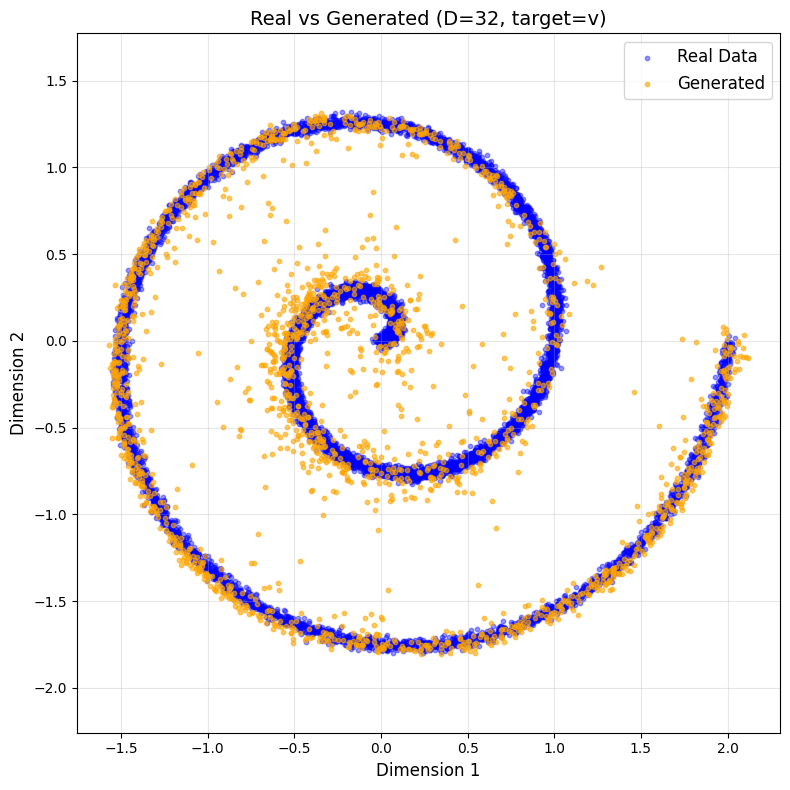


sampling - optimized Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: v
  Generating 2000 samples
tensor([1.1363e-01, 1.0000e-04, 1.0000e-04, 6.7244e-02, 1.0000e-04, 2.7342e-01,
        5.4565e-02, 1.0000e-04, 1.1412e-01, 2.5495e-02, 5.1586e-02, 5.5818e-02,
        1.9355e-01, 3.2012e-02, 3.8139e-03, 1.0734e-01, 6.7432e-02, 2.6840e-01,
        2.6125e-01, 4.5171e-02, 2.1048e-01, 1.4506e-01, 6.3805e-02, 2.7012e-01,
        2.0525e-02, 2.4159e-01, 2.5067e-02, 1.4856e-01, 2.7067e-01, 1.0000e-04,
        1.0000e-04, 6.3575e-02])
tensor([6.6541e-02, 2.9425e-01, 1.2541e-01, 1.7713e-01, 4.8293e-02, 1.3359e-01,
        2.4020e-01, 1.3026e-01, 5.2630e-04, 8.2337e-02, 3.8425e-01, 7.4373e-02,
        8.6927e-03, 1.0359e-01, 9.6575e-02, 9.0740e-02, 1.0612e-04, 7.6451e-02,
        1.0420e-03, 2.5830e-01, 1.6877e-02, 1.4532e-01, 1.2570e-01, 1.2520e-01,
        4.9605e-02, 1.1090e-01, 1.4971e-02, 6.4734e-04, 1.4575e-01, 3.9376e-02,
        3.4623e-02, 1.0000e-04])
tensor(

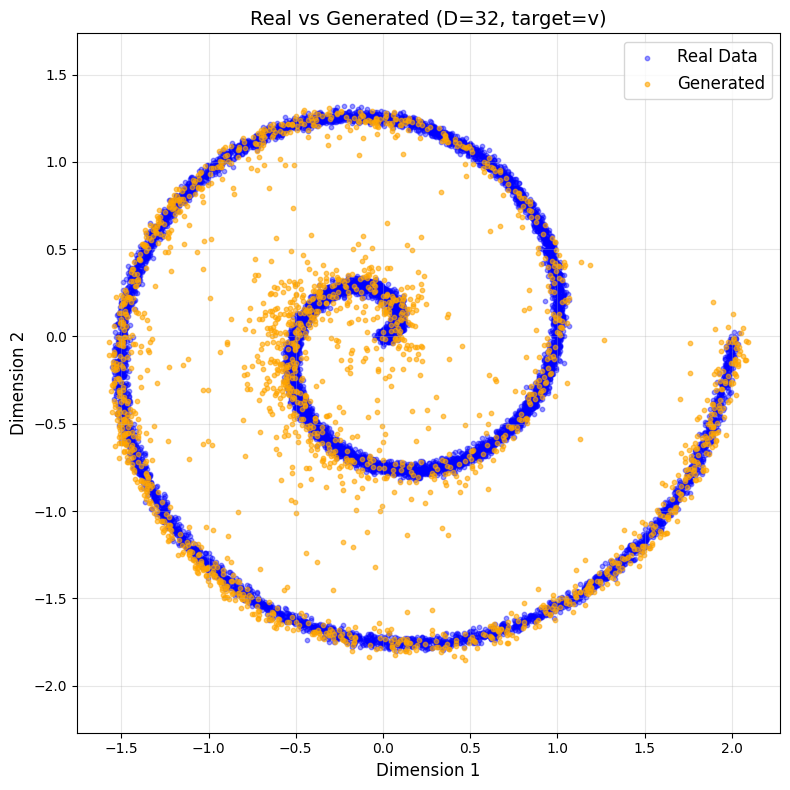

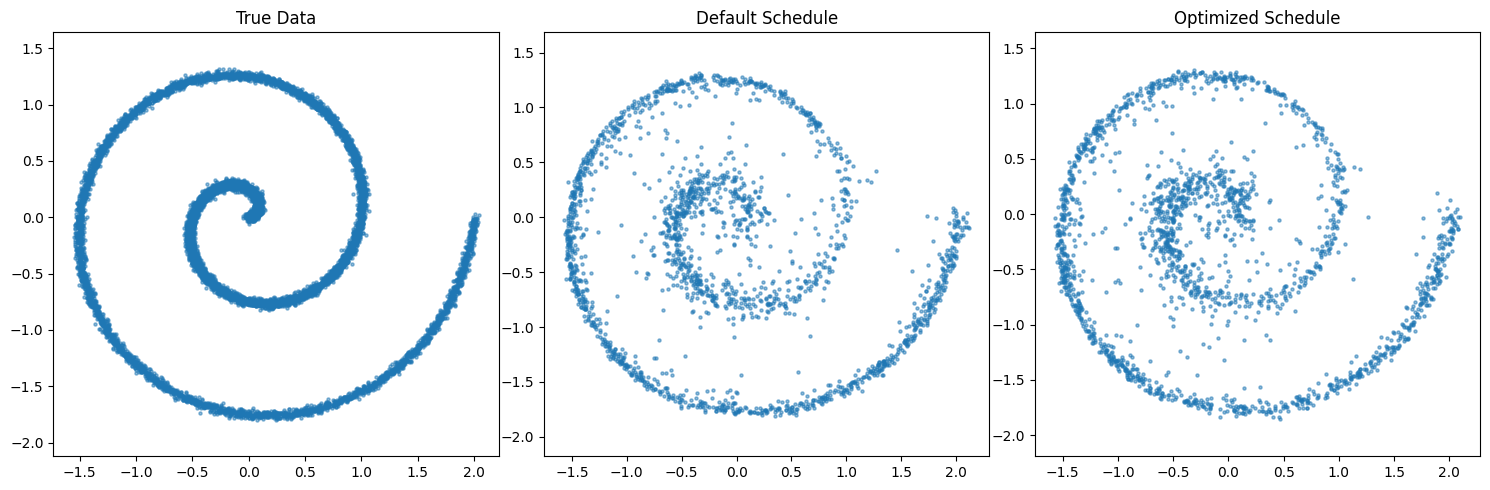

In [75]:
compare_schedules(model_v, P, t_uniform = t_random, t_optimized = t_optimized, x_true = x_hat, sigma = sigma,
                     n_points=2000, target_type="v", steps = 10)